### The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

**In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).**

#### Data Dictionary

* **survival**>>>>>>>>>>>>>> Survival	0 = No, 1 = Yes,

* **pclass**>>>>>>>>>>>>>>>	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

* **sex**>>>>>>>>>>>>>>>>>>>>>>>>>	Sex	

* **Age**>>>>>>>>>>>>>>>>>	Age in years	
* **sibsp** >>>>>>>>>>>>>>>	# of siblings / spouses aboard the Titanic	
* **parch**>>>>>>>>>>>>>>>>>>>>	# of parents / children aboard the Titanic	
* **ticket**>>>>>>>>>>>>>>>>>>>>>	Ticket number	
* **fare**>>>>>>>>>>>>>>>>>>>>>>	Passenger fare	
* **cabin**>>>>>>>>>>>>>>>>>>>>>>>	Cabin number	
* **embarked**>>>>>>>>>>>>>>>>>>>	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
* **pclass**:>>>>>>>>>>>>>>>>>>>>>>> A proxy for socio-economic status (SES)
* **1st = Upper**
* **2nd = Middle**
* **3rd = Lower**

* **age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* **sibsp**: The dataset defines family relations in this way...
* **Sibling** = brother, sister, stepbrother, stepsister
* **Spouse** = husband, wife (mistresses and fiancés were ignored)

* **parch**: The dataset defines family relations in this way...
* **Parent** = mother, father
* **Child** = daughter, son, stepdaughter, stepson
* Some children travelled only with a nanny, therefore parch=0 for them.

* **Here the Target Variable is Survival** (0=Not Survived,1=Survived)

###### Evaluation Metric:Your score is the percentage of passengers you correctly predict. This is known as accuracy.

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
import scipy.stats as stats
import statsmodels.api  as sma
from statsmodels.api import OLS
import statsmodels.formula.api as sfa
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,StackingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm  import LGBMClassifier


* **Load the Train and Test Data**

In [2]:
train=pd.read_csv(r"C:\Users\ASUS\Downloads\train (1).csv")
test=pd.read_csv(r"C:\Users\ASUS\Downloads\test (1).csv")

In [3]:
train.shape,test.shape

((891, 12), (418, 11))

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


###### Combine the Train and Test Dataset for further Analysis

In [6]:
combine=pd.concat([train,test],ignore_index=True)

In [7]:
combine.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [8]:
combine.shape

(1309, 12)

In [9]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [10]:
combine.isnull().sum()/combine.shape[0]
# More than 77% data for cabin is Missing

PassengerId    0.000000
Survived       0.319328
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.200917
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000764
Cabin          0.774637
Embarked       0.001528
dtype: float64

In [11]:
# Number of unique category in  each Features
combine.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

In [15]:
combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [16]:
cat_cols=combine.select_dtypes(include=object).columns
num_cols=combine.select_dtypes(include=np.number).columns

In [17]:
cat_cols
# Most of records in Name columns contains unique labels so i will not consider this columns for further visulaization
# Also cabin,Ticket most of the records are unique

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [18]:
num_cols
# Survived,Pclass,Sibsp,Parch are the categorical features

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [19]:
cat_cols=['Sex','Embarked','Survived','Pclass','SibSp','Parch']
num_cols=['Age','Fare']

# Univariate Analysis


#### Numerical Columns

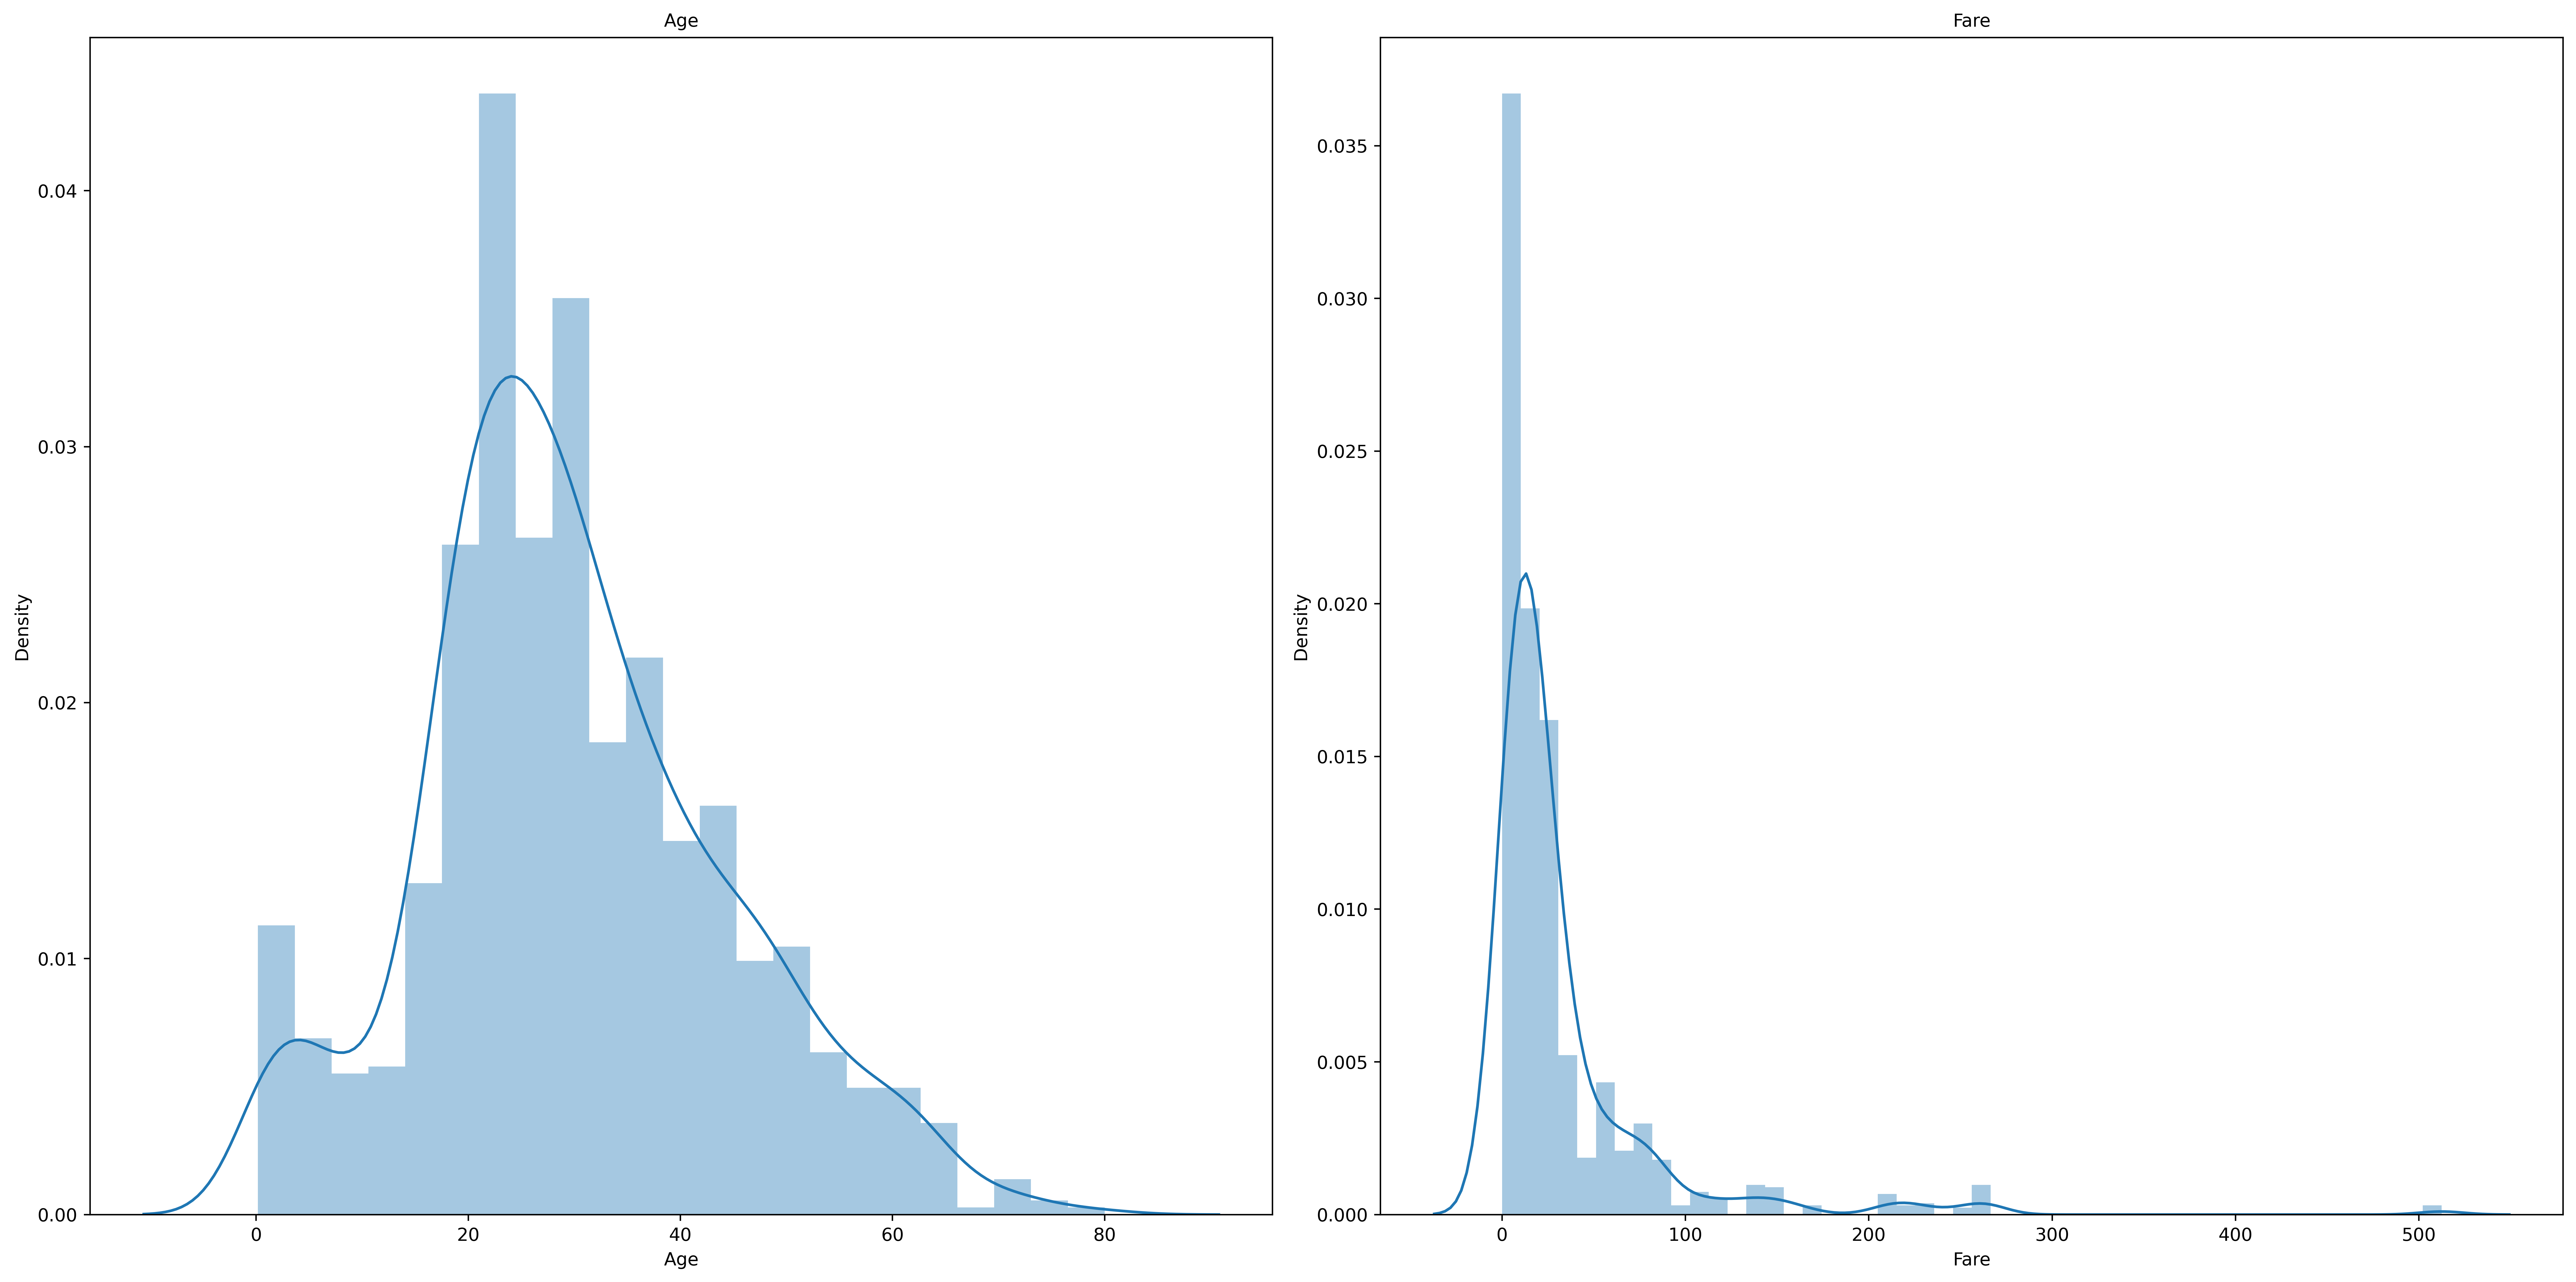

In [20]:
plt.figure(figsize=(20,10),dpi=500)
nrows=1
ncols=2
rep=1
for i in num_cols:
    plt.subplot(nrows,ncols,rep)
    sns.distplot(combine[i])
    rep=rep+1
    plt.title(i,fontdict={'fontsize':10})
plt.tight_layout()
plt.show()

#### Observation From the Above Distribution Plot
* Age we can see the distribution of age is looks like normal distributions and most of the passenger who are travelling are
  lies in the age range of 20 to 60.
* There are some Passenger who are more than 80 age also
* The distributions of Fare columns is looklikes highly right/positively skewed,it means that there are some passengers 
  who paid high amount,at Zero Fare amount the peak is high.
* So as i guess/my hpothesis ,imagine that the fare amount for which the passenger_id is zero he/she might be a staff/workers of titanic

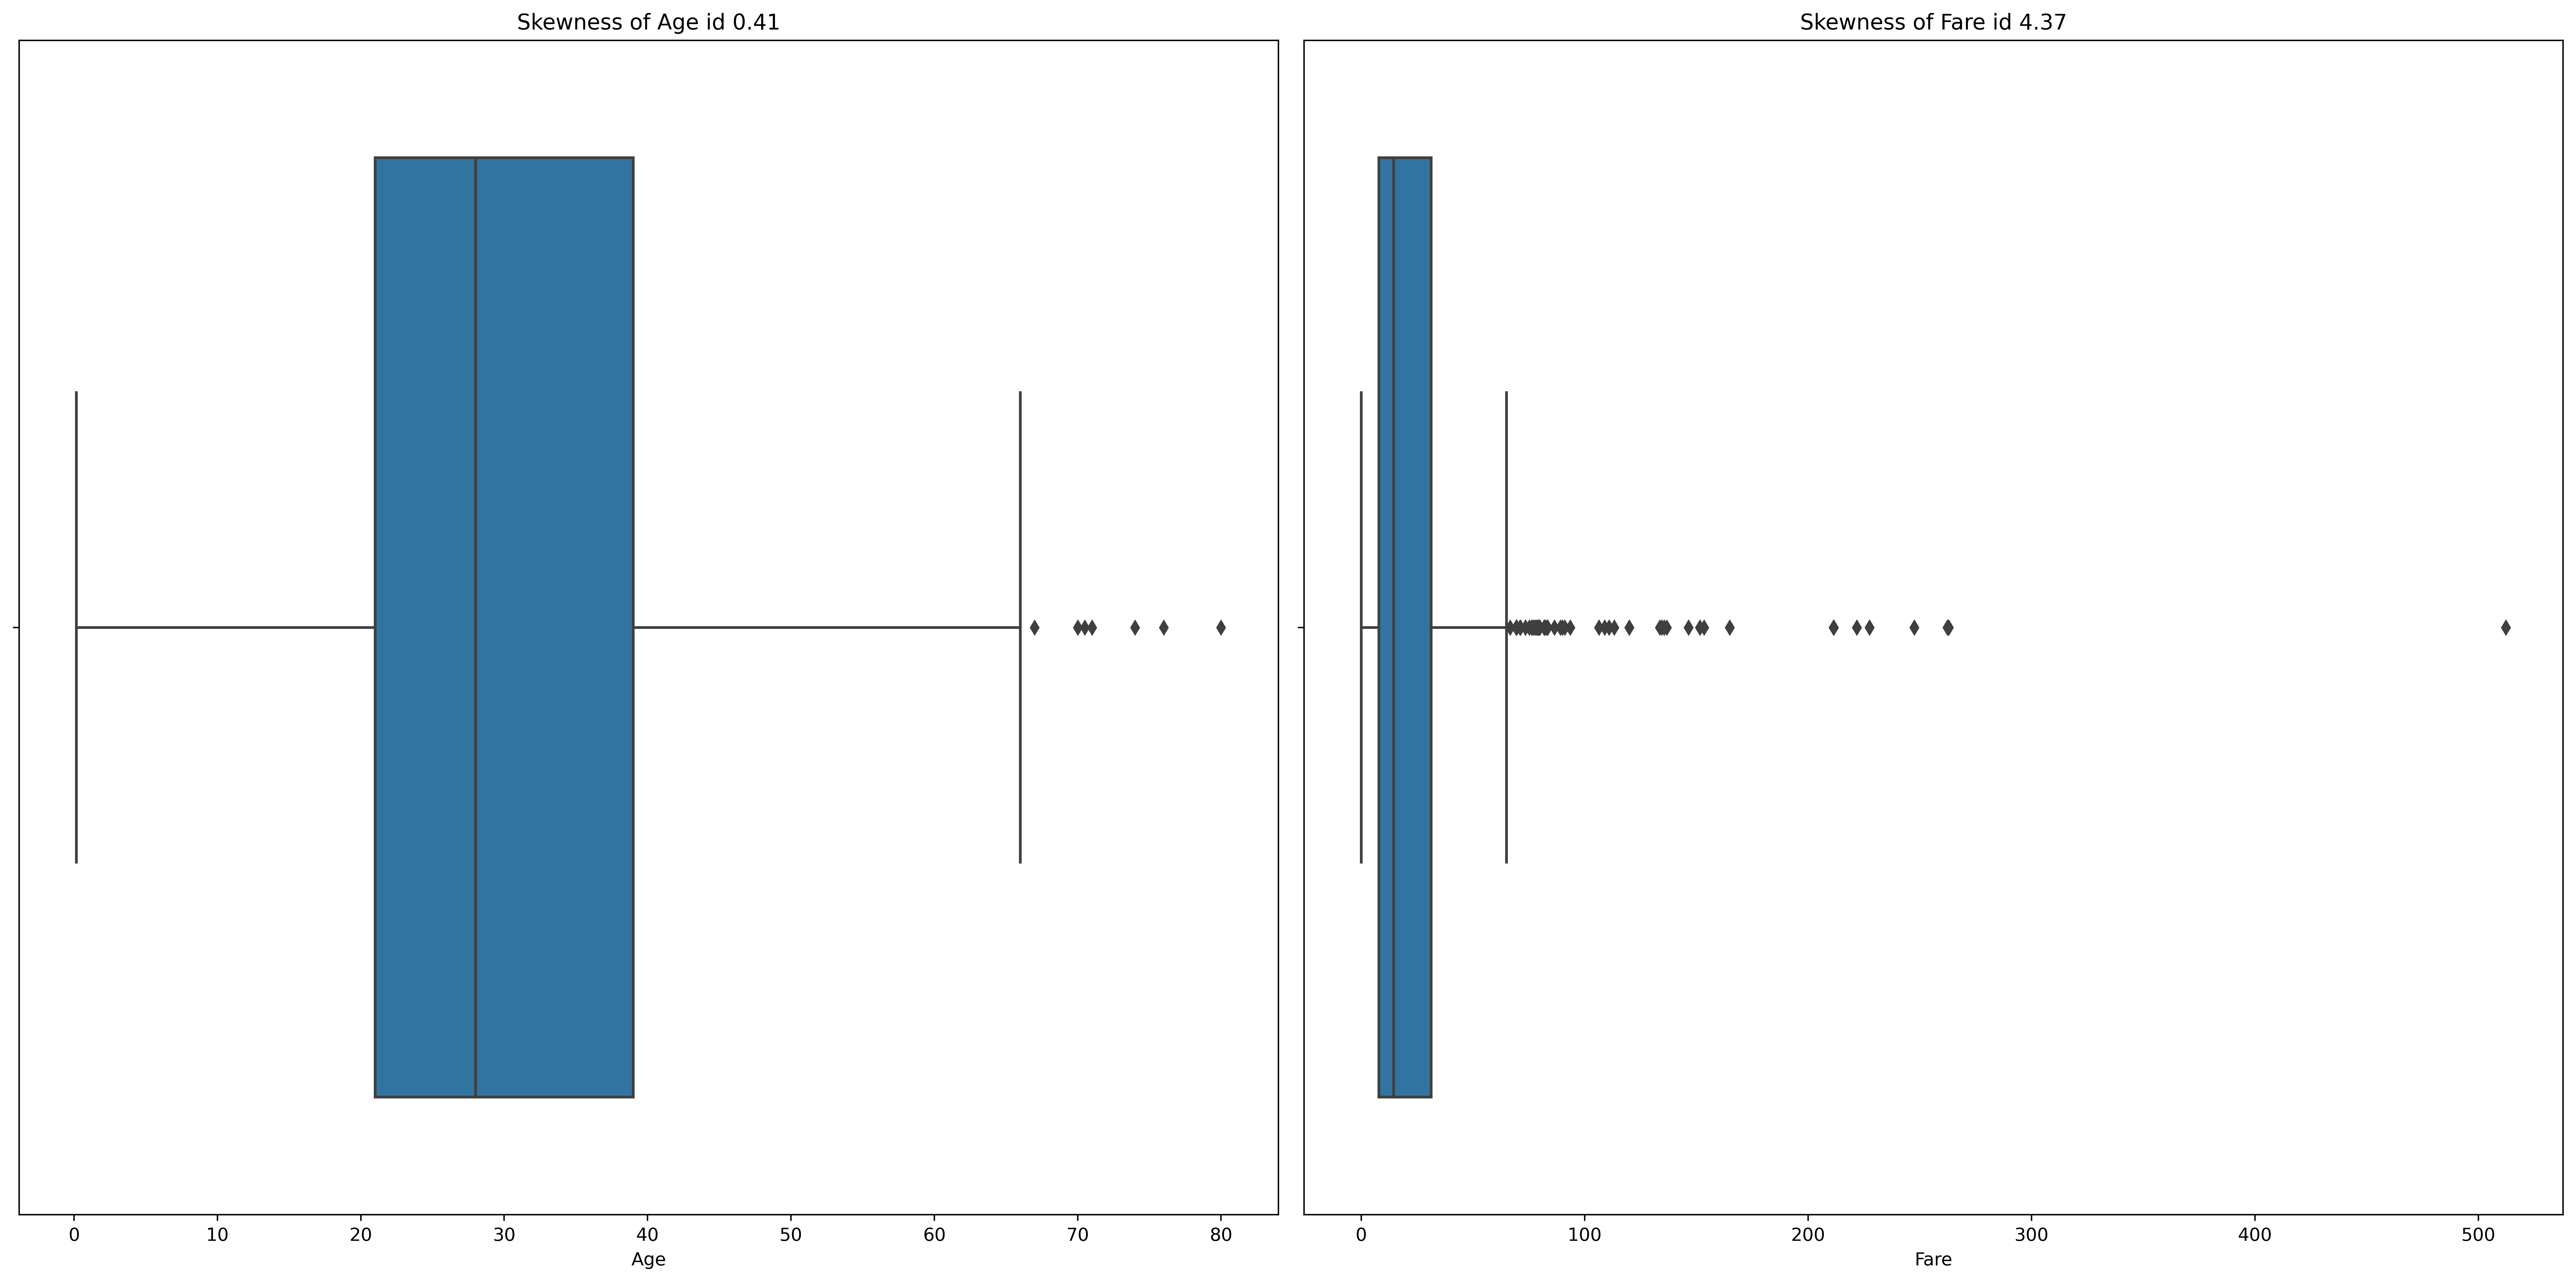

In [21]:
plt.figure(figsize=(20,10),dpi=500)
nrows=1
ncols=2
rep=1
for i in num_cols:
    plt.subplot(nrows,ncols,rep)
    sns.boxplot(combine[i])
    plt.title('Skewness of %s id %.2f'%(i,combine[i].skew()))
    rep=rep+1
plt.tight_layout()
plt.show()

### Categorical Columns

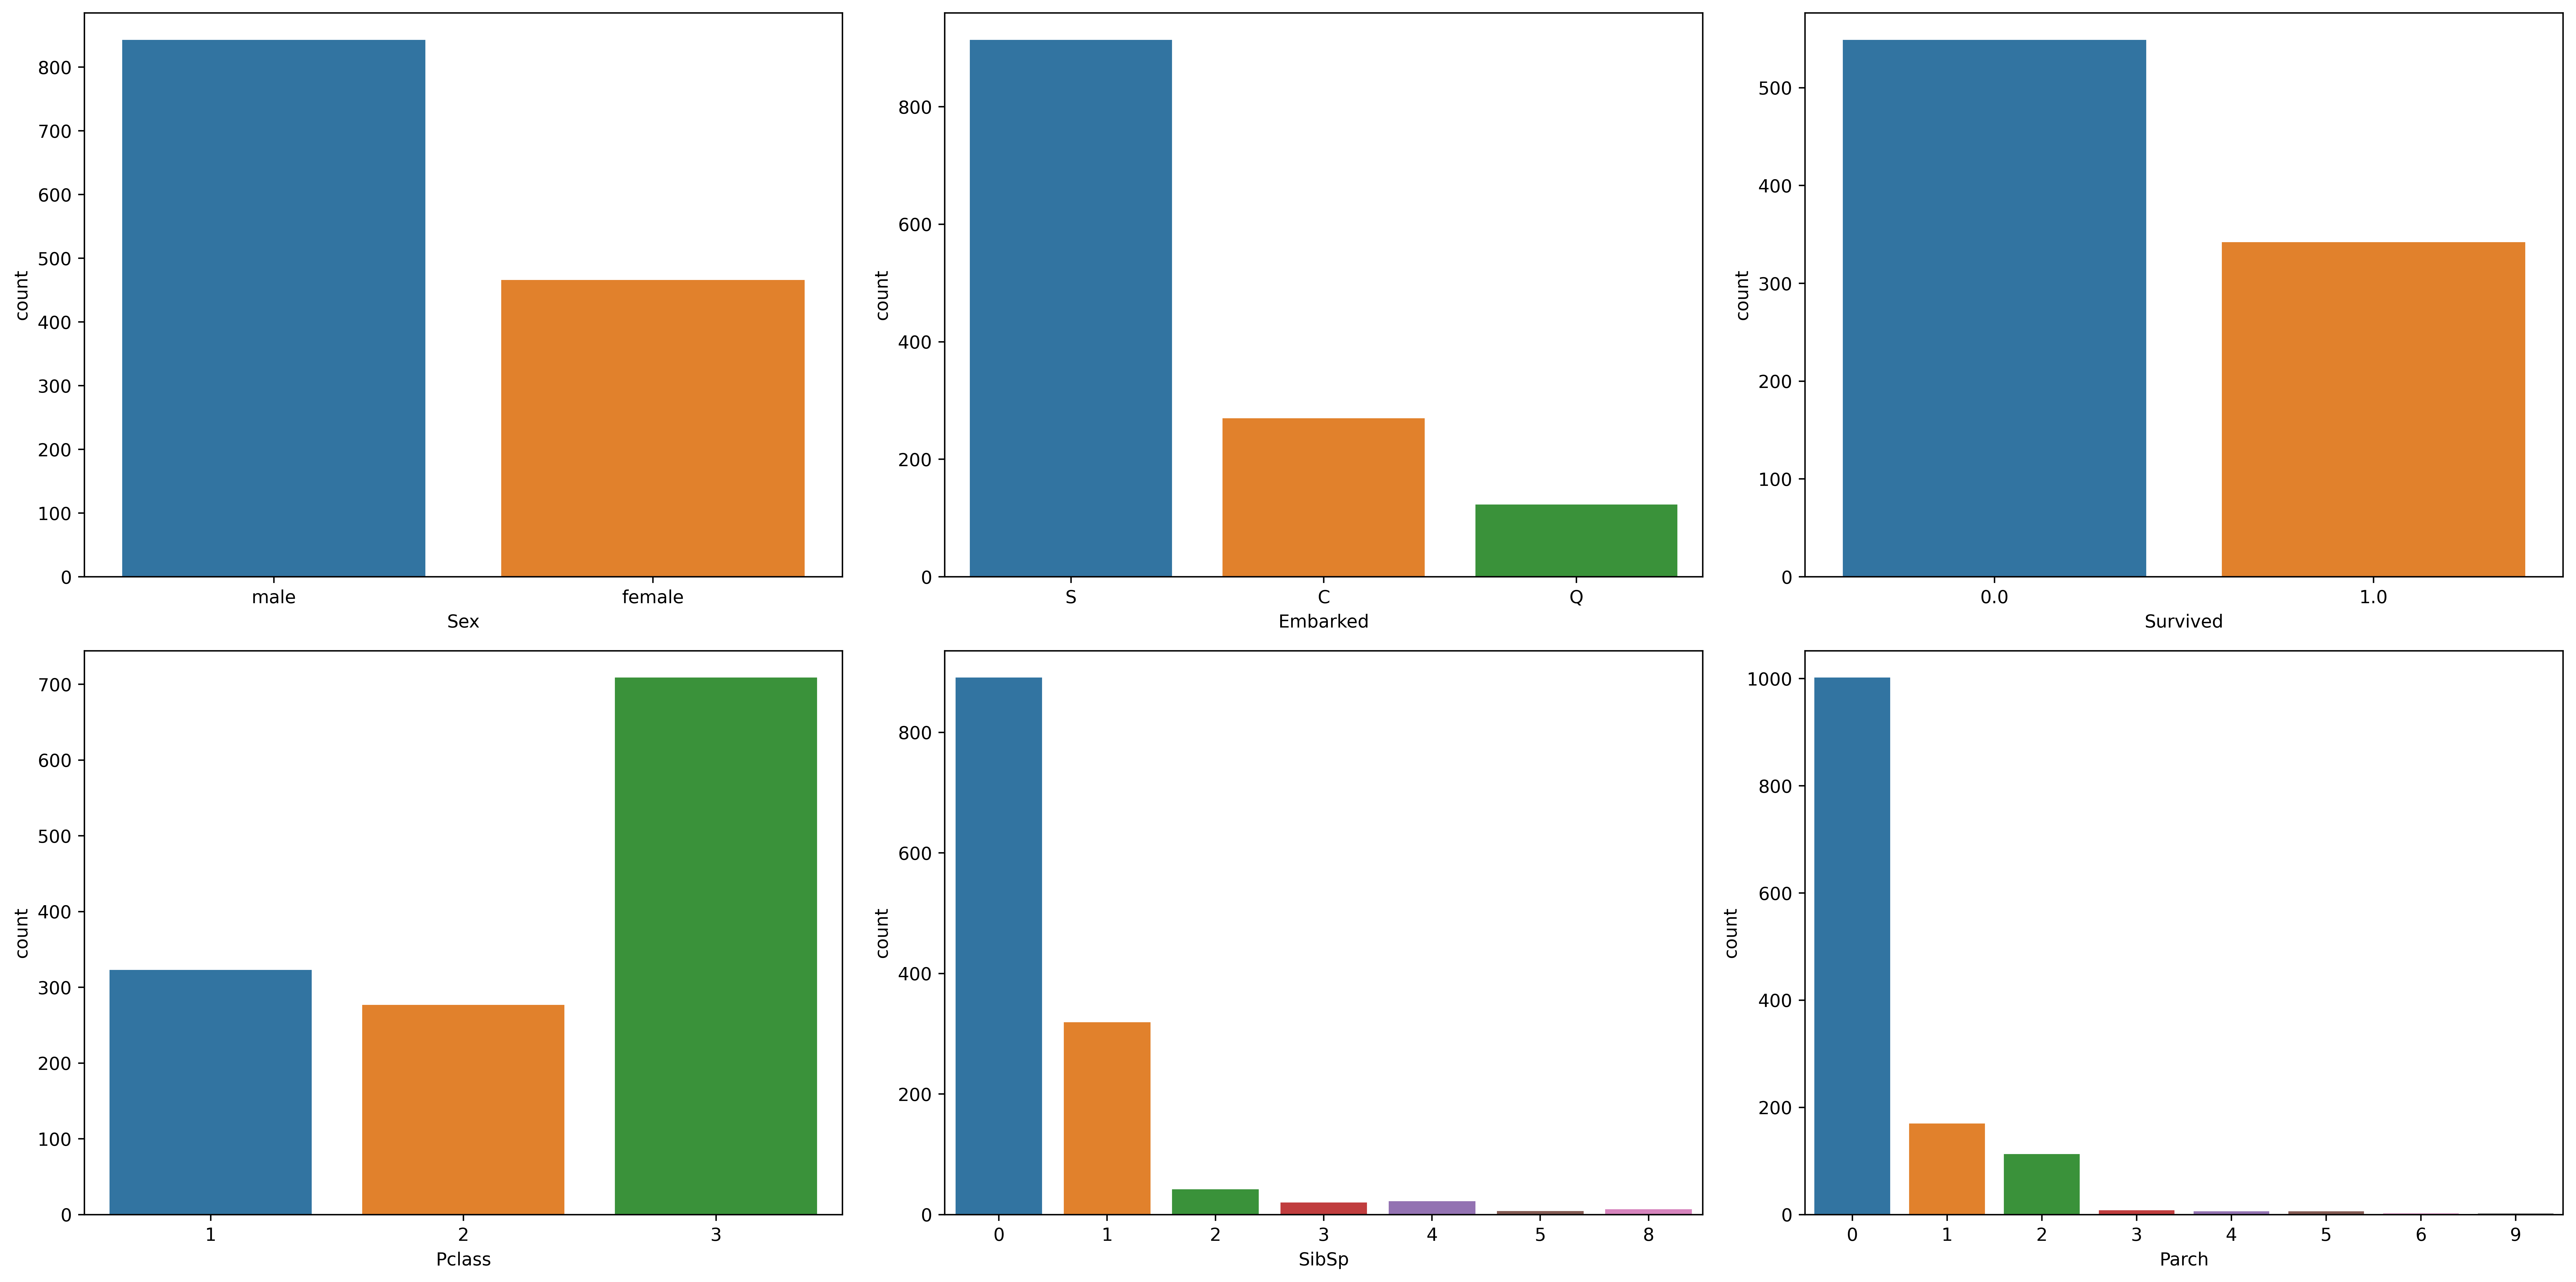

In [22]:
plt.figure(figsize=(20,10),dpi=500)
nrows=2
ncols=3
rep=1
for i in cat_cols:
    plt.subplot(nrows,ncols,rep)
    sns.countplot(combine[i])
    rep=rep+1
plt.tight_layout()
plt.show()

#### Obseravtion from the Above Plot
* Most of the Passengers who are Travelling are Male,Here i assume/think that Most of the passenger who not survived are Male
* Most of the passengers are started there journey from southhampton/ most of the Passengers belongs to southampton
* The number of passengers who died is more than the number of passengers who survived
* Most of the passenger who are traveling are belongs to pclass3,so my hopthesis  say that most of the passenger who died are belongs to pclass 3.
* Most of the passengers who are travellings are alone or i can say with one siblings or spouse and maximum sibings or spouse 
  a traveller travel with is 8 as seen from the above plot.
* A maximum of 9 parents/children traveled along with one of the traveler.Most of the passengers/travellers are travelling alone.




## Bivariate Analysis

### Numeric vs Categoric(Tgt)

In [28]:
plt.figure(figsize=(30,10),dpi=500)
nrows=1
ncols=2
rep=1
for i in num_cols:
    plt.subplot(nrows,ncols,rep)
    sns.boxplot(combine.Survived,combine[i])
    rep=rep+1
plt.tight_layout()
plt.show()

#### Observation From the above plot:
* Passenger who are younger are high chance of survival as compared to older.
* The passenger who paid the high fare amount are high chance of survival.

### Categoric vs Categoric(Tgt)

In [29]:
#Pclass vs Survived
pd.crosstab(combine.Pclass,combine.Survived)

Survived,0.0,1.0
Pclass,,
1,80,136
2,97,87
3,372,119


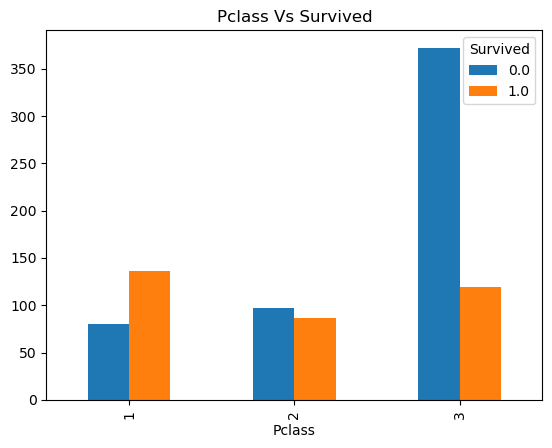

In [30]:
pd.crosstab(combine.Pclass,combine.Survived).plot(kind='bar')
plt.title('Pclass Vs Survived')
plt.show()
#class 3 passenger are the most who did not survived as compare to others class passenger and class 1 passenger are
#higher survival rates...

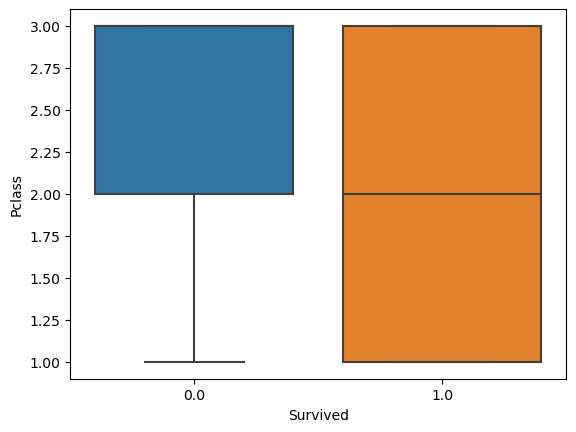

In [31]:
sns.boxplot(combine.Survived,combine.Pclass)
plt.show()

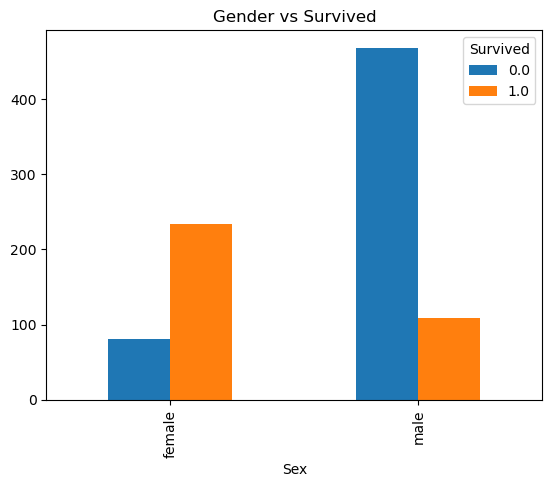

In [32]:
pd.crosstab(combine.Sex,combine.Survived).plot(kind='bar')
plt.title('Gender vs Survived')
plt.show()

# Feamle passenger are Survived the most as compare to Male

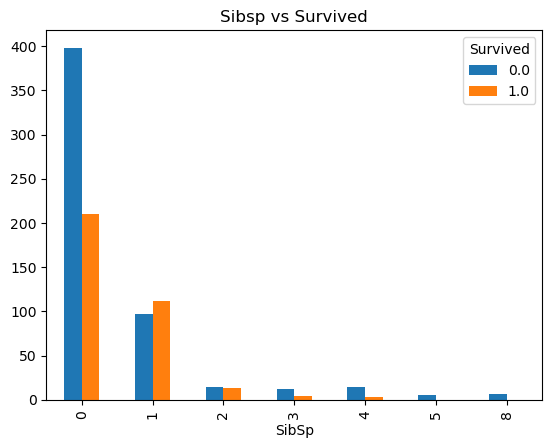

In [33]:
# Sibsp vs Survived
pd.crosstab(combine.SibSp,combine.Survived).plot(kind='bar')
plt.title('Sibsp vs Survived')
plt.show()
#Singles and couples are survived the most

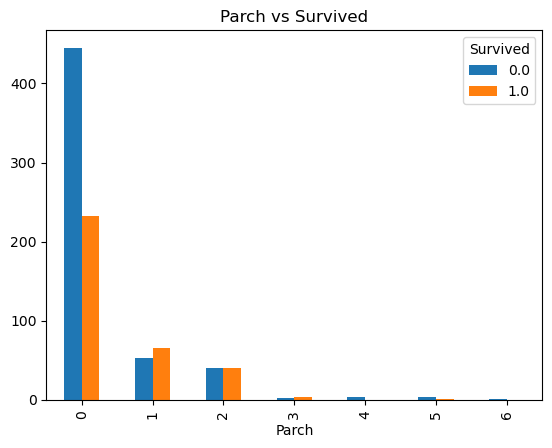

In [34]:
# Parch vs Survived
pd.crosstab(combine.Parch,combine.Survived).plot(kind='bar')
plt.title('Parch vs Survived')
plt.show()
# Solo travellers and two family members are able to survived most.....

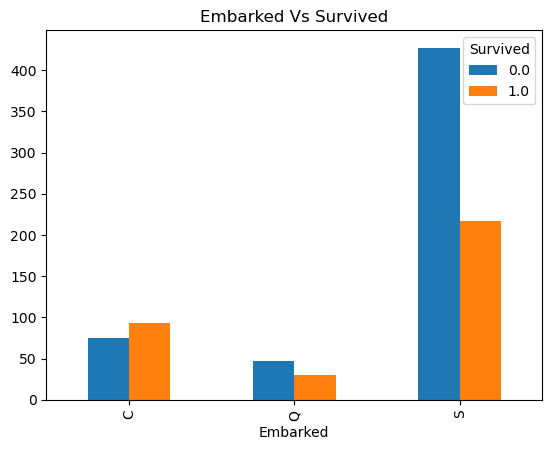

In [35]:
# Embarked vs Survived
pd.crosstab(combine.Embarked,combine.Survived).plot(kind='bar')
plt.title('Embarked Vs Survived')
plt.show()
#chebourgs have high chances of survival...

In [36]:
combine.groupby('Embarked')['Survived'].value_counts(normalize=True)
# people from chebourgs are survived more in terms of percentage approx 55%

Embarked  Survived
C         1.0         0.553571
          0.0         0.446429
Q         0.0         0.610390
          1.0         0.389610
S         0.0         0.663043
          1.0         0.336957
Name: Survived, dtype: float64

In [37]:
combine.groupby(['Embarked','Pclass'])['Survived'].value_counts(normalize=True)

Embarked  Pclass  Survived
C         1       1.0         0.694118
                  0.0         0.305882
          2       1.0         0.529412
                  0.0         0.470588
          3       0.0         0.621212
                  1.0         0.378788
Q         1       0.0         0.500000
                  1.0         0.500000
          2       1.0         0.666667
                  0.0         0.333333
          3       0.0         0.625000
                  1.0         0.375000
S         1       1.0         0.582677
                  0.0         0.417323
          2       0.0         0.536585
                  1.0         0.463415
          3       0.0         0.810198
                  1.0         0.189802
Name: Survived, dtype: float64

## Missing Values

In [38]:
combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [39]:
(combine.isnull().sum()/combine.shape[0])*100
# Approx 21% data of Age are Missing
# Approx 78% data of Cambin are Mising
# The missing value which show in survived actually it is from the test dataset and as we know in test their is no target variable
# so we will drop this columns later from the test dataset

PassengerId     0.000000
Survived       31.932773
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
dtype: float64

In [40]:
combine.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [41]:
combine.groupby(['Pclass','Sex'])['Age'].describe()

count       mean        std   min   25%   50%    75%   max
Pclass Sex                                                               
1      female  133.0  37.037594  14.272460  2.00  24.0  36.0  48.00  76.0
       male    151.0  41.029272  14.578529  0.92  30.0  42.0  50.00  80.0
2      female  103.0  27.499223  12.911747  0.92  20.0  28.0  34.00  60.0
       male    158.0  30.815380  13.977400  0.67  23.0  29.5  38.75  70.0
3      female  152.0  22.185329  12.205254  0.17  16.0  22.0  30.00  63.0
       male    349.0  25.962264  11.682415  0.33  20.0  25.0  32.00  74.0

* **Lets split the Name of the passengers,as each name of the passengers contains salutation so,I can extract the salutaion and see the distribution of age accordingly**

In [42]:
combine.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [43]:
combine.Name[0].split(", ")[1].split(". ")[0]

'Mr'

In [44]:
# Extracting Salutation from each Name
title=[]
for i in combine.Name:
    title.append(i.split(', ')[1].split('.')[0])
    

In [45]:
combine['Title']=pd.Series(title)

In [46]:
combine.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr


In [47]:
# Lest see the distribution of Salutation in the dataset
combine.Title.value_counts(normalize=True)

Mr              0.578304
Miss            0.198625
Mrs             0.150497
Master          0.046600
Rev             0.006112
Dr              0.006112
Col             0.003056
Mlle            0.001528
Major           0.001528
Ms              0.001528
Lady            0.000764
Sir             0.000764
Mme             0.000764
Don             0.000764
Capt            0.000764
the Countess    0.000764
Jonkheer        0.000764
Dona            0.000764
Name: Title, dtype: float64

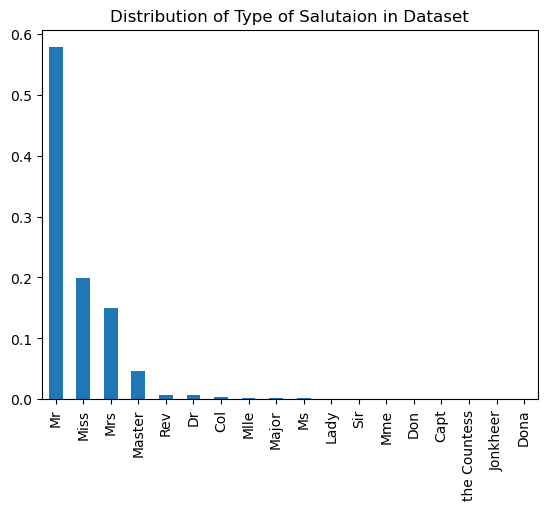

In [48]:
combine.Title.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Type of Salutaion in Dataset')
plt.show()
# So from the below plot i can say that most of the person who are travelling are Mr(Mister)>age18 and followes by Miss,Mrs,Master

In [49]:
# Now lets check the Age distribution with Respect to Title
combine.groupby('Title')['Age'].describe()
# This distribution of Age Make More sense

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Capt,1.0,70.000000,NaN,70.00,70.00,70.0,70.00,70.0
Col,4.0,54.000000,5.477226,47.00,51.50,54.5,57.00,60.0
Don,1.0,40.000000,NaN,40.00,40.00,40.0,40.00,40.0
Dona,1.0,39.000000,NaN,39.00,39.00,39.0,39.00,39.0
Dr,7.0,43.571429,11.731115,23.00,38.00,49.0,51.50,54.0
Jonkheer,1.0,38.000000,NaN,38.00,38.00,38.0,38.00,38.0
Lady,1.0,48.000000,NaN,48.00,48.00,48.0,48.00,48.0
Major,2.0,48.500000,4.949747,45.00,46.75,48.5,50.25,52.0
Master,53.0,5.482642,4.161554,0.33,2.00,4.0,9.00,14.5


In [50]:
combine.Title.unique()
# There are total 18 unique title

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [51]:
title_ignore=['Don', 'Rev', 'Dr', 'Mme',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona']
len(title_ignore)

13

* **Binnig the title columns from 18 categories to 6 categories as must of the person belongs to the title (Mr,Mrs,Miss,Master,Ms) and rest of the title grouping with others category**

In [52]:
def ignore(x):
    if x in title_ignore:
        return ('Others')
    else:
        return (x)

In [53]:
combine['Titles']=combine.Title.apply(ignore)

In [54]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Titles
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr


In [55]:
combine.groupby('Titles')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Titles,,,,,,,,
Master,53.0,5.482642,4.161554,0.33,2.0,4.0,9.0,14.5
Miss,210.0,21.774238,12.249077,0.17,15.0,22.0,30.0,63.0
Mr,581.0,32.252151,12.422089,11.00,23.0,29.0,39.0,80.0
Mrs,170.0,36.994118,12.901767,14.00,27.0,35.5,46.5,76.0
Ms,1.0,28.000000,NaN,28.00,28.0,28.0,28.0,28.0
Others,31.0,43.129032,12.309189,23.00,32.5,45.0,52.5,70.0


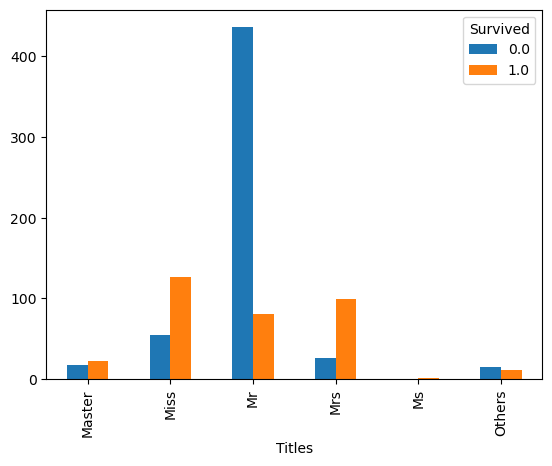

In [56]:
pd.crosstab(combine.Titles,combine.Survived).plot(kind='bar')
plt.show()
# Mr(Mister) Person are Died/Not Survived the Most as compares to others category

In [57]:
# Dealing with Missing value of Age as per the Titles Column
combine['Age']=combine.groupby('Titles')['Age'].apply(lambda x:x.fillna(x.median()))

In [58]:
combine.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Titles
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,Mr


In [59]:
combine.groupby('Titles')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Titles,,,,,,,,
Master,61.0,5.288197,3.906924,0.33,2.00,4.0,8.00,14.5
Miss,260.0,21.817654,11.003754,0.17,17.00,22.0,27.00,63.0
Mr,757.0,31.496037,10.966971,11.00,25.00,29.0,35.00,80.0
Mrs,197.0,36.789340,11.991282,14.00,28.00,35.5,45.00,76.0
Ms,2.0,28.000000,0.000000,28.00,28.00,28.0,28.00,28.0
Others,32.0,43.187500,12.113542,23.00,32.75,45.0,52.25,70.0


In [61]:
combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Title             0
Titles            0
dtype: int64

In [62]:
# Dealing with the Missing values in Fare columns

In [63]:
combine.loc[combine.Fare.isnull(),['Fare']]=combine.loc[(combine.Titles=='Mr')&(combine.Pclass==3)&(combine.Embarked=='S')]['Fare'].median()

In [64]:
combine.loc[(combine.Titles=='Mr')&(combine.Pclass==3)&(combine.Embarked=='S')]['Fare'].median()

7.925

In [65]:
combine.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
Title             0
Titles            0
dtype: int64

In [ ]:
# Dealing with Missin Value of Cabin

In [67]:
combine.Cabin.value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: Cabin, Length: 186, dtype: int64

In [68]:
combine.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [69]:
cabin_avbl=['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46', 'D30',
       'E121', 'D11', 'E77', 'F38', 'B3', 'D6', 'B82 B84', 'D17', 'A36',
       'B102', 'B69', 'E49', 'C47', 'D28', 'E17', 'A24', 'C50', 'B42',
       'C148', 'B45', 'B36', 'A21', 'D34', 'A9', 'C31', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C55 C57', 'C116', 'F', 'A29', 'C6', 'C28',
       'C51', 'C97', 'D22', 'B10', 'E45', 'E52', 'A11', 'B11', 'C80',
       'C89', 'F E46', 'B26', 'F E57', 'A18', 'E60', 'E39 E41',
       'B52 B54 B56', 'C39', 'B24', 'D40', 'D38', 'C105']

In [70]:
len(cabin_avbl)
#Total 187 cabin are availabels

186

In [71]:
def available(x):
    if x in cabin_avbl:
        return ('Cabin Available')
    else:
        return('Cabin Not_Available')

In [72]:
# AS 77% of data in cabin columns are missing so we extract a new columns from cabin that is Cabin Avalability
combine['Cabin_Avalability']=combine.Cabin.apply(available)

In [73]:
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Titles,Cabin_Avalability
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,Cabin Not_Available
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,Cabin Available
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,Cabin Not_Available
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,Cabin Available
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,Cabin Not_Available


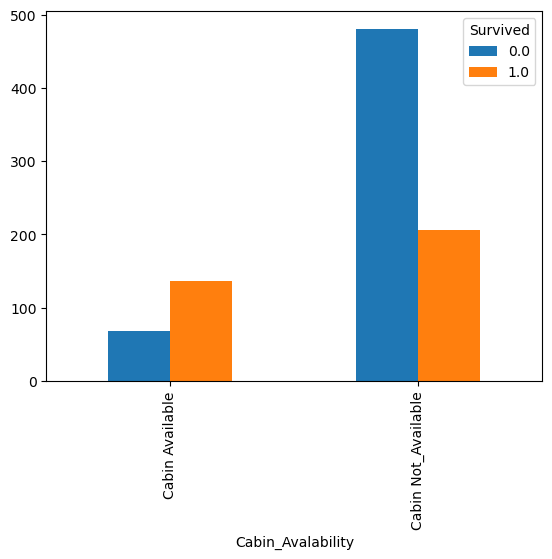

In [74]:
pd.crosstab(combine.Cabin_Avalability,combine.Survived).plot(kind='bar')
plt.show()
#Inference: Cabin_Available passengers are survived more as compare to Cabin not available Passengers

In [75]:
combine.Cabin_Avalability.value_counts()

Cabin Not_Available    1014
Cabin Available         295
Name: Cabin_Avalability, dtype: int64

In [76]:
combine.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Titles,Cabin_Avalability
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,Mr,Cabin Not_Available


* **In column Cabin approx 77% data are missing,so as per theory it say that if there will be any columns contains missing
value more than 60% we simply drops but i am not dropping here i extract a intelligence from this and create a new columns
Cabin_Avalability and Check the relation with Target it make more sense**

In [69]:
combine.isnull().sum()

PassengerId             0
Survived              418
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                1014
Embarked                2
Title                   0
Titles                  0
Cabin_Avalability       0
dtype: int64

In [78]:
new_data=combine.drop(['Name','PassengerId','Ticket','Cabin','Title'],axis=1)
# Drop the Unncessary columns 

In [79]:
new_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,Cabin Not_Available
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,Cabin Available
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,Cabin Not_Available
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,Cabin Available
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,Cabin Not_Available


In [80]:
# Family
# Combine all the attributes like,SibSp,Parch
new_data['Family']=new_data.SibSp+new_data.Parch+1

In [81]:
new_data.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family
0,0.0,3,male,22.0,1,0,7.25,S,Mr,Cabin Not_Available,2


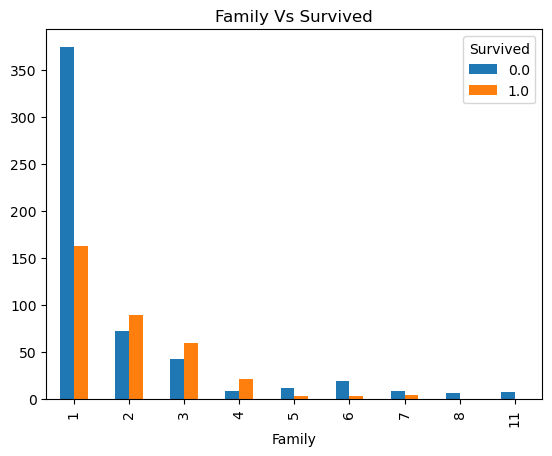

In [82]:
pd.crosstab(new_data.Family,new_data.Survived).plot(kind='bar')
plt.title('Family Vs Survived')
plt.show()
#People who are travelling alone and copules are high chance of survival

In [83]:
# Binnig Family
new_data
def fam(x):
    if x>=5:
        return ('Large_Family')
    elif (x>=3):
        return ('Small_Family')
    elif (x==2):
        return ('Couples')
    else:
        return ('Singles')

In [84]:
new_data['Family_Cat']=new_data.Family.apply(fam)

In [85]:
new_data.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat
0,0.0,3,male,22.0,1,0,7.25,S,Mr,Cabin Not_Available,2,Couples


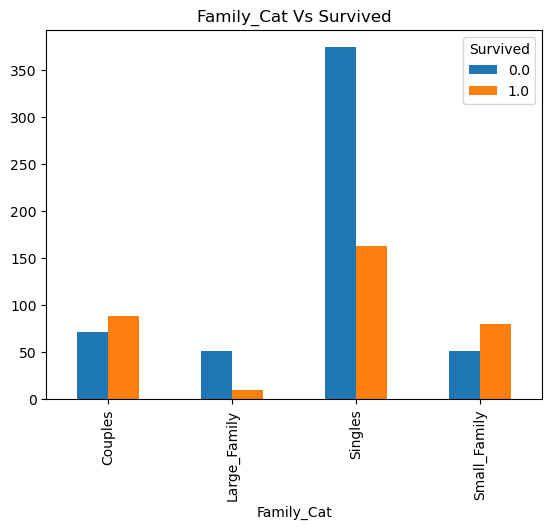

In [86]:
pd.crosstab(new_data.Family_Cat,new_data.Survived).plot(kind='bar')
plt.title('Family_Cat Vs Survived')
plt.show()
# Couples and Small_Family passengers are high chance of survival

In [87]:
new_data.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat
0,0.0,3,male,22.0,1,0,7.25,S,Mr,Cabin Not_Available,2,Couples


In [88]:
# Fare Per Person
new_data['Fare_Per_Head']=new_data.Fare/new_data.Family

In [90]:
new_data.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat,Fare_Per_Head
0,0.0,3,male,22.0,1,0,7.25,S,Mr,Cabin Not_Available,2,Couples,3.625


In [91]:
new_data[new_data.Fare==0]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat,Fare_Per_Head
179,0.0,3,male,36.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
263,0.0,1,male,40.0,0,0,0.0,S,Mr,Cabin Available,1,Singles,0.0
271,1.0,3,male,25.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
277,0.0,2,male,29.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
302,0.0,3,male,19.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
413,0.0,2,male,29.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
466,0.0,2,male,29.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
481,0.0,2,male,29.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
597,0.0,3,male,49.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0
633,0.0,1,male,29.0,0,0,0.0,S,Mr,Cabin Not_Available,1,Singles,0.0


In [92]:
new_data.isnull().sum()

Survived             418
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               2
Titles                 0
Cabin_Avalability      0
Family                 0
Family_Cat             0
Fare_Per_Head          0
dtype: int64

In [93]:
new_data.loc[(new_data.Pclass==3)&(new_data.Titles=='Mr')&(new_data.Cabin_Avalability=='Cabin Not_Available')&
       (new_data.Family_Cat=='Singles'),'Fare'].median()

7.8958

In [94]:
new_data.loc[new_data.Fare.isnull(),'Fare']=new_data.loc[(new_data.Pclass==3)&(new_data.Titles=='Mr')&(new_data.Cabin_Avalability=='Cabin Not_Available')&
       (new_data.Family_Cat=='Singles'),'Fare'].median()

In [95]:
new_data.isnull().sum()

Survived             418
Pclass                 0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
Embarked               2
Titles                 0
Cabin_Avalability      0
Family                 0
Family_Cat             0
Fare_Per_Head          0
dtype: int64

In [96]:
new_data[new_data.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat,Fare_Per_Head
61,1.0,1,female,38.0,0,0,80.0,NaN,Miss,Cabin Available,1,Singles,80.0
829,1.0,1,female,62.0,0,0,80.0,NaN,Mrs,Cabin Available,1,Singles,80.0


In [97]:
new_data.loc[
            (new_data.Sex=='female')&(new_data.Family_Cat=='Singles')&(new_data.Pclass==1),'Embarked'].mode()[0]

'C'

In [98]:
new_data.loc[new_data.Embarked.isnull(),'Embarked']='C'

In [99]:
new_data.Survived.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [100]:
new_data['Magic_1']=new_data.groupby(['Sex','Embarked','Titles','Cabin_Avalability'])['Pclass'].transform('count')

In [101]:
new_data['Magic_2']=new_data.groupby(['Pclass','Embarked','Titles','Cabin_Avalability','Family_Cat'])['Fare'].transform('median')

In [102]:
new_data.head(1)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
0,0.0,3,male,22.0,1,0,7.25,S,Mr,Cabin Not_Available,2,Couples,3.625,480,15.025


In [103]:
new_data.corr()
# Magic_2,Fare_per_head,Fare,Pclass,Magic_1 are having good correlation with Target

,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Fare_Per_Head,Magic_1,Magic_2
Survived,1.000000,-0.338481,-0.071235,-0.035322,0.081629,0.257307,0.016639,0.221600,-0.456498,0.318082
Pclass,-0.338481,1.000000,-0.391580,0.060832,0.018322,-0.558742,0.050027,-0.504336,0.336720,-0.646534
Age,-0.071235,-0.391580,1.000000,-0.214428,-0.129649,0.179632,-0.211904,0.193300,0.016422,0.192402
SibSp,-0.035322,0.060832,-0.214428,1.000000,0.373587,0.160389,0.861952,-0.089666,-0.149930,0.209397
Parch,0.081629,0.018322,-0.129649,0.373587,1.000000,0.221668,0.792296,-0.065370,-0.204599,0.288079
Fare,0.257307,-0.558742,0.179632,0.160389,0.221668,1.000000,0.226654,0.832045,-0.296807,0.763642
Family,0.016639,0.050027,-0.211904,0.861952,0.792296,0.226654,1.000000,-0.094708,-0.210445,0.295187
Fare_Per_Head,0.221600,-0.504336,0.193300,-0.089666,-0.065370,0.832045,-0.094708,1.000000,-0.213136,0.492650
Magic_1,-0.456498,0.336720,0.016422,-0.149930,-0.204599,-0.296807,-0.210445,-0.213136,1.000000,-0.352488
Magic_2,0.318082,-0.646534,0.192402,0.209397,0.288079,0.763642,0.295187,0.492650,-0.352488,1.000000


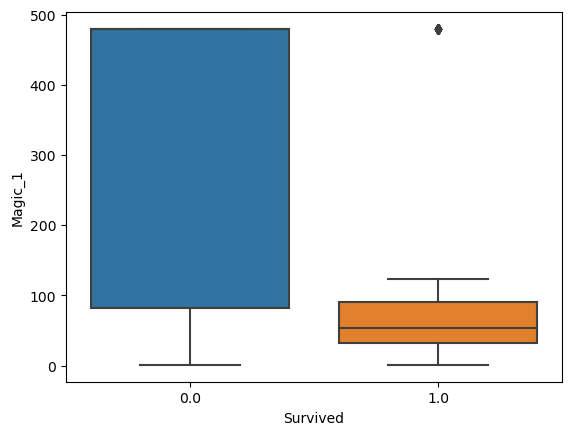

In [104]:
sns.boxplot(new_data.Survived,new_data.Magic_1)
plt.show()

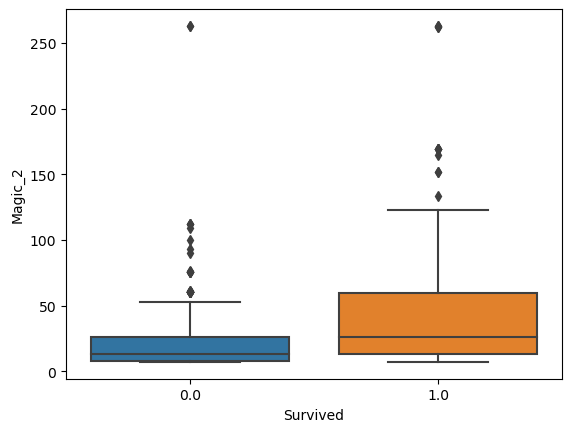

In [105]:
sns.boxplot(new_data.Survived,new_data.Magic_2)
plt.show()

In [106]:
new_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,Cabin Not_Available,2,Couples,3.62500,480,15.0250
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,Cabin Available,2,Couples,35.64165,32,83.1583
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,Cabin Not_Available,1,Singles,7.92500,123,7.9250
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,Cabin Available,2,Couples,26.55000,43,60.0000
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,Cabin Not_Available,1,Singles,8.05000,480,7.8958


#### Lets perform Statistical Test with Target for all the features

In [102]:
new_data.nunique()

Survived               2
Pclass                 3
Sex                    2
Age                   99
SibSp                  7
Parch                  8
Fare                 281
Embarked               3
Title                 18
Titles                 6
Cabin_Avalability      2
Family                 9
Family_Cat             4
Fare_Per_Head        339
Magic_1               22
Magic_2               92
dtype: int64

In [103]:
new_data.select_dtypes(include=np.number).columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
       'Fare_Per_Head', 'Magic_1', 'Magic_2'],
      dtype='object')

In [104]:
new_data.select_dtypes(include=object).columns

Index(['Sex', 'Embarked', 'Title', 'Titles', 'Cabin_Avalability',
       'Family_Cat'],
      dtype='object')

In [107]:
num_cols=['Age','Fare','Fare_Per_Head', 'Magic_1', 'Magic_2','Family']
cat_cols=['Sex', 'Embarked', 'Title', 'Titles', 'Cabin_Avalability',
       'Family_Cat','Pclass','Sibsp',]

#### Numeric vs Tgt

In [108]:
# Ho: Feature is not significant
# Ha: Feature is significant
for i in num_cols:
    sample1=new_data.groupby(['Survived'])[i].apply(list)[0]
    sample2=new_data.groupby(['Survived'])[i].apply(list)[1]
    ttest,pvalue=stats.ttest_ind(sample1,sample2)
    print(i,'---------',(pvalue))
# Except Family all features are significant with the Target

Age --------- 0.03349912645306346
Fare --------- 6.120189341924198e-15
Fare_Per_Head --------- 2.2513313600580802e-11
Magic_1 --------- 4.511072934019039e-47
Magic_2 --------- 2.1329303602597073e-22
Family --------- 0.6198911221343028


##### Categoric Vs Tgt

In [109]:
for i in cat_cols:
    table=pd.crosstab(new_data.Sex,new_data.Survived)
    teststats,pvalue,dof,expected=stats.chi2_contingency(table)
    print(i,'-------------',pvalue)
# All the Features are Statistically Significant with Target

Sex ------------- 1.1973570627755645e-58
Embarked ------------- 1.1973570627755645e-58
Title ------------- 1.1973570627755645e-58
Titles ------------- 1.1973570627755645e-58
Cabin_Avalability ------------- 1.1973570627755645e-58
Family_Cat ------------- 1.1973570627755645e-58
Pclass ------------- 1.1973570627755645e-58
Sibsp ------------- 1.1973570627755645e-58


In [111]:
# Drop the Insignificant columns from the Above Analysis
new_data.drop(columns=['Family'],inplace=True)

In [112]:
#Spilt train,test data set
train.shape,test.shape

((891, 12), (418, 11))

In [113]:
newtrain=new_data.loc[0:train.shape[0]-1,:]

In [114]:
newtrain.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,Cabin Not_Available,Couples,3.62500,480,15.0250
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,Cabin Available,Couples,35.64165,32,83.1583
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,Cabin Not_Available,Singles,7.92500,123,7.9250
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,Cabin Available,Couples,26.55000,43,60.0000
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,Cabin Not_Available,Singles,8.05000,480,7.8958


In [115]:
new_test=new_data.loc[train.shape[0]:,:]

In [117]:
new_test.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
891,NaN,3,male,34.5,0,0,7.8292,Q,Mr,Cabin Not_Available,Singles,7.829200,55,7.75000
892,NaN,3,female,47.0,1,0,7.0000,S,Mrs,Cabin Not_Available,Couples,3.500000,90,15.85000
893,NaN,2,male,62.0,0,0,9.6875,Q,Mr,Cabin Not_Available,Singles,9.687500,55,11.52915
894,NaN,3,male,27.0,0,0,8.6625,S,Mr,Cabin Not_Available,Singles,8.662500,480,7.89580
895,NaN,3,female,22.0,1,1,12.2875,S,Mrs,Cabin Not_Available,Small_Family,4.095833,90,18.05625


In [118]:
newtrain.shape,new_test.shape

((891, 14), (418, 14))

In [119]:
new_test.drop(columns='Survived',inplace=True)

In [120]:
new_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
891,3,male,34.5,0,0,7.8292,Q,Mr,Cabin Not_Available,Singles,7.829200,55,7.75000
892,3,female,47.0,1,0,7.0000,S,Mrs,Cabin Not_Available,Couples,3.500000,90,15.85000
893,2,male,62.0,0,0,9.6875,Q,Mr,Cabin Not_Available,Singles,9.687500,55,11.52915
894,3,male,27.0,0,0,8.6625,S,Mr,Cabin Not_Available,Singles,8.662500,480,7.89580
895,3,female,22.0,1,1,12.2875,S,Mrs,Cabin Not_Available,Small_Family,4.095833,90,18.05625


In [121]:
newtrain.shape,new_test.shape

((891, 14), (418, 13))

## Scaling

In [122]:
newtrain.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,Cabin Not_Available,Couples,3.62500,480,15.0250
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,Cabin Available,Couples,35.64165,32,83.1583
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,Cabin Not_Available,Singles,7.92500,123,7.9250
3,1.0,1,female,35.0,1,0,53.1000,S,Mrs,Cabin Available,Couples,26.55000,43,60.0000
4,0.0,3,male,35.0,0,0,8.0500,S,Mr,Cabin Not_Available,Singles,8.05000,480,7.8958


In [123]:
# Convert the Tgt into Int
newtrain['Survived']=newtrain.Survived.astype('int')

In [124]:
newtrain.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Cabin_Avalability,Family_Cat,Fare_Per_Head,Magic_1,Magic_2
0,0,3,male,22.0,1,0,7.2500,S,Mr,Cabin Not_Available,Couples,3.62500,480,15.0250
1,1,1,female,38.0,1,0,71.2833,C,Mrs,Cabin Available,Couples,35.64165,32,83.1583


In [125]:
# Scale the Age,Fare and Fare_per_Head,Magic_1,Magic_2
cols=['Age','Fare','Fare_Per_Head','Magic_1','Magic_2']
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
for i in cols:
    newtrain.loc[:,cols]=sc.fit_transform(newtrain.loc[:,cols])
    new_test.loc[:,cols]=sc.transform(new_test.loc[:,cols])

<AxesSubplot:xlabel='Fare', ylabel='Density'>

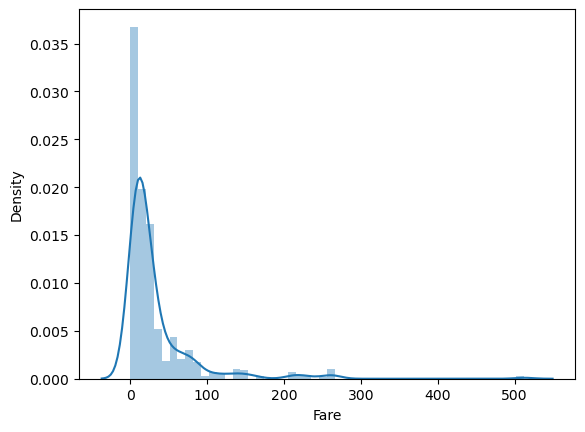

In [126]:
sns.distplot(combine.Fare)

<AxesSubplot:ylabel='Density'>

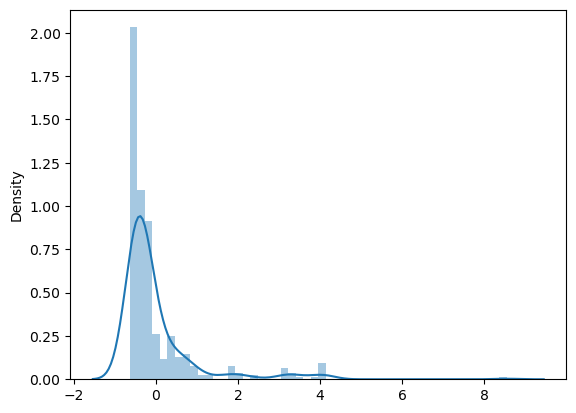

In [127]:
sns.distplot(sc.fit_transform(pd.DataFrame(new_test['Fare'])))

In [128]:
combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.429465,0.498854,0.385027,33.276098
std,378.020061,0.486592,0.837836,13.159685,1.041658,0.865560,51.743631
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,35.500000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [129]:
newtrain.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_Per_Head,Magic_1,Magic_2
count,891.000000,891.000000,8.910000e+02,891.000000,891.000000,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,0.383838,2.308642,7.812681e-17,0.523008,0.381594,-4.373606e-17,-2.460932e-17,6.915531e-17,7.488710e-17
std,0.486592,0.836071,1.000562e+00,1.102743,0.806057,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,0.000000,1.000000,-2.183420e+00,0.000000,0.000000,-6.484217e-01,-5.559950e-01,-1.081510e+00,-5.996047e-01
25%,0.000000,2.000000,-5.523069e-01,0.000000,0.000000,-4.891482e-01,-3.536006e-01,-8.301961e-01,-5.800427e-01
50%,0.000000,3.000000,-2.321571e-02,0.000000,0.000000,-3.573909e-01,-3.242883e-01,-6.429428e-01,-3.825683e-01
75%,1.000000,3.000000,4.680833e-01,1.000000,0.000000,-2.424635e-02,1.046949e-01,1.278867e+00,6.862474e-02
max,1.000000,3.000000,3.831592e+00,8.000000,6.000000,9.667167e+00,1.374643e+01,1.278867e+00,6.906218e+00


In [130]:
new_test.describe()

,Pclass,Age,SibSp,Parch,Fare,Fare_Per_Head,Magic_1,Magic_2
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.028952,0.447368,0.392344,0.067586,0.051773,-0.051499,0.055014
std,0.841838,0.982886,0.896760,0.981429,1.124662,0.993924,0.985018,1.145694
min,1.000000,-2.202316,0.000000,0.000000,-0.648422,-0.555995,-1.081510,-0.628035
25%,1.000000,-0.552307,0.000000,0.000000,-0.489442,-0.342869,-0.830196,-0.580043
50%,3.000000,-0.023216,0.000000,0.000000,-0.357391,-0.314169,-0.642943,-0.370830
75%,3.000000,0.496427,1.000000,0.000000,-0.014745,0.169354,1.278867,0.068625
max,3.000000,3.529254,8.000000,9.000000,9.667167,6.768591,1.278867,6.906218


In [131]:
dummytrain=pd.get_dummies(newtrain,drop_first=True)
dummytest=pd.get_dummies(new_test,drop_first=True)

In [132]:
dummytrain.shape,dummytest.shape

((891, 21), (418, 20))

In [134]:
dummytrain.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Fare_Per_Head,Magic_1,Magic_2,Sex_male,Embarked_Q,Embarked_S,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Ms,Titles_Others,Cabin_Avalability_Cabin Not_Available,Family_Cat_Large_Family,Family_Cat_Singles,Family_Cat_Small_Family
0,0,3,-0.552307,1,0,-0.502445,-0.454798,1.278867,-0.370830,1,0,1,0,1,0,0,0,1,0,0,0
1,1,1,0.657044,1,0,0.786845,0.438994,-0.928750,1.628602,0,0,0,0,0,1,0,0,0,0,0,0
2,1,3,-0.249969,0,0,-0.488854,-0.334757,-0.480328,-0.579186,0,0,1,1,0,0,0,0,1,0,1,0
3,1,1,0.430291,1,0,0.420730,0.185187,-0.874546,0.949001,0,0,1,0,0,1,0,0,0,0,0,0
4,0,3,0.430291,0,0,-0.486337,-0.331267,1.278867,-0.580043,1,0,1,0,1,0,0,0,1,0,1,0


In [135]:
dummytest.head()

,Pclass,Age,SibSp,Parch,Fare,Fare_Per_Head,Magic_1,Magic_2,Sex_male,Embarked_Q,Embarked_S,Titles_Miss,Titles_Mr,Titles_Mrs,Titles_Ms,Titles_Others,Cabin_Avalability_Cabin Not_Available,Family_Cat_Large_Family,Family_Cat_Singles,Family_Cat_Small_Family
891,3,0.392499,0,0,-0.490783,-0.337431,-0.815413,-0.584321,1,1,0,0,1,0,0,0,1,0,1,0
892,3,1.337305,1,0,-0.507479,-0.458287,-0.642943,-0.346620,0,0,1,0,0,1,0,0,1,0,0,0
893,2,2.471071,0,0,-0.453367,-0.285554,-0.815413,-0.473419,1,1,0,0,1,0,0,0,1,0,1,0
894,3,-0.174385,0,0,-0.474005,-0.314169,1.278867,-0.580043,1,0,1,0,1,0,0,0,1,0,1,0
895,3,-0.552307,1,1,-0.401017,-0.441654,-0.642943,-0.281875,0,0,1,0,0,1,0,0,1,0,0,1


* **Data is ready for Modelling***

### Lets Build a Base Model

In [136]:
X=dummytrain.drop(columns=['Survived'])
y=dummytrain.Survived

In [139]:
# 70:30 train test spilt
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=12,stratify=y,test_size=0.30)

In [140]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape

((623, 20), (623,), (268, 20), (268,))

In [141]:
xtrain_c=sma.add_constant(xtrain)
xtest_c=sma.add_constant(xtest)

In [143]:
base_model=OLS(ytrain,xtrain_c).fit()

In [146]:
print(base_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     28.65
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           3.86e-74
Time:                        17:04:01   Log-Likelihood:                -226.48
No. Observations:                 623   AIC:                             495.0
Df Residuals:                     602   BIC:                             588.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [154]:
y_pred_logit=base_model.predict(xtest_c)

In [155]:
y_pred_logit=pd.Series(np.where(y_pred_logit>0.50,1,0))

In [156]:
y_pred_logit.value_counts()

0    170
1     98
dtype: int64

In [158]:
# Lets check the accuracy of Base Model
print('Accuracy:',accuracy_score(ytest,y_pred_logit))

Accuracy: 0.8246268656716418


In [160]:
# Lets check the classification report
from sklearn.metrics import classification_report,f1_score,confusion_matrix
print('Classification_Report:\n',classification_report(ytest,y_pred_logit))
print('F1_score:',f1_score(ytest,y_pred_logit))

Classification_Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       165
           1       0.79      0.75      0.77       103

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268

F1_score: 0.7661691542288557


###### Obseravtion from Base Model: The accuracy is comes out to be  approx 82% and the F1score is approx 77%

#### Lets Apply diffrent Machine Learning Model

In [291]:
def base_models():
    models=dict()
    models['Logistic Regression']=LogisticRegression()
    models['Decission Tree']=DecisionTreeClassifier()
    models['Random Forest']=RandomForestClassifier()
    models['Naive Bayes']=GaussianNB()
    models['KNN']=KNeighborsClassifier()
    models['Ada Boost']=AdaBoostClassifier()
    models['Xgboost']=XGBClassifier()
    models['Catboost']=CatBoostClassifier()
    models['Light gbm']=LGBMClassifier()
    models['GBM']=GradientBoostingClassifier()
    return models

In [292]:
def evaluation_score(model):
    Cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=12)
    score=cross_val_score(estimator=model,X=X,y=y,scoring='accuracy',cv=Cv,error_score='raise',n_jobs=-1)
    return score

In [293]:
models=base_models()
result,names=list(),list()
for name,model in models.items():
    finalscore=evaluation_score(model)
    result.append(finalscore)
    names.append(name)
    print('Model:',names[-1],'Mean_Score:',np.mean(result),'Variance:',np.std(result))

Model: Logistic Regression Mean_Score: 0.8260247316552632 Variance: 0.013913779169667266
Model: Decission Tree Mean_Score: 0.80301613206955 Variance: 0.028210216458651263
Model: Random Forest Mean_Score: 0.8061996526688008 Variance: 0.02475119001760794
Model: Naive Bayes Mean_Score: 0.7962949595128994 Variance: 0.03149685558068008
Model: KNN Mean_Score: 0.7968526771702968 Variance: 0.03018038131493353
Model: Ada Boost Mean_Score: 0.8009666687590232 Variance: 0.029609669554725052
Model: Xgboost Mean_Score: 0.8037420303630836 Variance: 0.028992386693470297
Model: Catboost Mean_Score: 0.8082088381143681 Variance: 0.030791241173247164
Model: Light gbm Mean_Score: 0.8095620697591697 Variance: 0.03063652214878835
Model: GBM Mean_Score: 0.8118818655451636 Variance: 0.03004796148614997


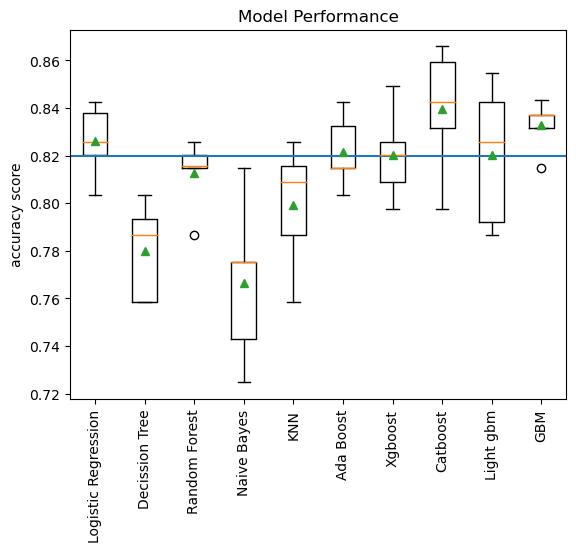

In [303]:
plt.boxplot(result,labels=names,showmeans=True)
plt.xticks(rotation=90)
plt.axhline(y=0.82)
plt.ylabel('accuracy score')
plt.title('Model Performance')
plt.show()

In [ ]:
# Lets combine top 4 models,Logistic Regression,Xgboost,catboost,Light gbm

In [332]:
base=[('log_reg',LogisticRegression()),('xgb',XGBClassifier()),('lgbm',LGBMClassifier())]
final=[('catboost',CatBoostClassifier())]

In [333]:
Cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [334]:
stack=StackingClassifier(estimators=base,final_estimator=CatBoostClassifier(),cv=Cv) 

In [335]:
model_stack=stack.fit(X,y)

Learning rate set to 0.009807
0:	learn: 0.6857858	total: 6.46ms	remaining: 6.45s
1:	learn: 0.6788111	total: 12.1ms	remaining: 6.01s
2:	learn: 0.6718737	total: 18.2ms	remaining: 6.04s
3:	learn: 0.6654531	total: 24.1ms	remaining: 6.01s
4:	learn: 0.6588398	total: 30ms	remaining: 5.98s
5:	learn: 0.6525838	total: 35.7ms	remaining: 5.91s
6:	learn: 0.6463383	total: 41.7ms	remaining: 5.92s
7:	learn: 0.6401280	total: 47.1ms	remaining: 5.84s
8:	learn: 0.6342333	total: 52.4ms	remaining: 5.77s
9:	learn: 0.6285755	total: 58.6ms	remaining: 5.8s
10:	learn: 0.6229949	total: 64.7ms	remaining: 5.82s
11:	learn: 0.6174131	total: 70.9ms	remaining: 5.83s
12:	learn: 0.6120732	total: 77.3ms	remaining: 5.87s
13:	learn: 0.6068155	total: 83.8ms	remaining: 5.9s
14:	learn: 0.6018925	total: 90.2ms	remaining: 5.92s
15:	learn: 0.5969722	total: 96.5ms	remaining: 5.93s
16:	learn: 0.5918990	total: 103ms	remaining: 5.94s
17:	learn: 0.5871567	total: 109ms	remaining: 5.96s
18:	learn: 0.5824771	total: 115ms	remaining: 5.95s

190:	learn: 0.3673173	total: 1.18s	remaining: 5s
191:	learn: 0.3671264	total: 1.18s	remaining: 4.98s
192:	learn: 0.3669290	total: 1.19s	remaining: 4.96s
193:	learn: 0.3667183	total: 1.19s	remaining: 4.95s
194:	learn: 0.3663355	total: 1.2s	remaining: 4.94s
195:	learn: 0.3661335	total: 1.2s	remaining: 4.93s
196:	learn: 0.3659548	total: 1.21s	remaining: 4.93s
197:	learn: 0.3657696	total: 1.22s	remaining: 4.93s
198:	learn: 0.3655192	total: 1.22s	remaining: 4.92s
199:	learn: 0.3651999	total: 1.23s	remaining: 4.92s
200:	learn: 0.3650166	total: 1.24s	remaining: 4.91s
201:	learn: 0.3647001	total: 1.24s	remaining: 4.91s
202:	learn: 0.3644695	total: 1.25s	remaining: 4.9s
203:	learn: 0.3641294	total: 1.25s	remaining: 4.89s
204:	learn: 0.3638678	total: 1.26s	remaining: 4.89s
205:	learn: 0.3635362	total: 1.27s	remaining: 4.88s
206:	learn: 0.3632242	total: 1.27s	remaining: 4.87s
207:	learn: 0.3629468	total: 1.28s	remaining: 4.86s
208:	learn: 0.3627776	total: 1.28s	remaining: 4.86s
209:	learn: 0.3624

351:	learn: 0.3388599	total: 2.14s	remaining: 3.94s
352:	learn: 0.3387649	total: 2.15s	remaining: 3.94s
353:	learn: 0.3386475	total: 2.16s	remaining: 3.94s
354:	learn: 0.3385788	total: 2.16s	remaining: 3.93s
355:	learn: 0.3384836	total: 2.17s	remaining: 3.92s
356:	learn: 0.3383942	total: 2.17s	remaining: 3.92s
357:	learn: 0.3382272	total: 2.18s	remaining: 3.91s
358:	learn: 0.3380931	total: 2.19s	remaining: 3.91s
359:	learn: 0.3378436	total: 2.19s	remaining: 3.9s
360:	learn: 0.3376474	total: 2.2s	remaining: 3.9s
361:	learn: 0.3374677	total: 2.21s	remaining: 3.89s
362:	learn: 0.3373692	total: 2.21s	remaining: 3.88s
363:	learn: 0.3372358	total: 2.22s	remaining: 3.88s
364:	learn: 0.3370785	total: 2.23s	remaining: 3.87s
365:	learn: 0.3369953	total: 2.23s	remaining: 3.87s
366:	learn: 0.3368891	total: 2.24s	remaining: 3.86s
367:	learn: 0.3368133	total: 2.25s	remaining: 3.85s
368:	learn: 0.3366887	total: 2.25s	remaining: 3.85s
369:	learn: 0.3366044	total: 2.26s	remaining: 3.84s
370:	learn: 0.3

538:	learn: 0.3151401	total: 3.33s	remaining: 2.84s
539:	learn: 0.3150667	total: 3.33s	remaining: 2.84s
540:	learn: 0.3149023	total: 3.34s	remaining: 2.83s
541:	learn: 0.3148117	total: 3.34s	remaining: 2.83s
542:	learn: 0.3146297	total: 3.35s	remaining: 2.82s
543:	learn: 0.3145420	total: 3.36s	remaining: 2.81s
544:	learn: 0.3143778	total: 3.36s	remaining: 2.81s
545:	learn: 0.3143068	total: 3.37s	remaining: 2.8s
546:	learn: 0.3141841	total: 3.38s	remaining: 2.8s
547:	learn: 0.3140292	total: 3.38s	remaining: 2.79s
548:	learn: 0.3139625	total: 3.39s	remaining: 2.79s
549:	learn: 0.3138486	total: 3.4s	remaining: 2.78s
550:	learn: 0.3136962	total: 3.4s	remaining: 2.77s
551:	learn: 0.3135709	total: 3.41s	remaining: 2.77s
552:	learn: 0.3135016	total: 3.42s	remaining: 2.76s
553:	learn: 0.3134067	total: 3.42s	remaining: 2.75s
554:	learn: 0.3132519	total: 3.43s	remaining: 2.75s
555:	learn: 0.3130696	total: 3.44s	remaining: 2.74s
556:	learn: 0.3128477	total: 3.44s	remaining: 2.74s
557:	learn: 0.31

718:	learn: 0.2928221	total: 4.48s	remaining: 1.75s
719:	learn: 0.2926320	total: 4.49s	remaining: 1.74s
720:	learn: 0.2925142	total: 4.49s	remaining: 1.74s
721:	learn: 0.2923714	total: 4.5s	remaining: 1.73s
722:	learn: 0.2921504	total: 4.51s	remaining: 1.73s
723:	learn: 0.2920526	total: 4.51s	remaining: 1.72s
724:	learn: 0.2919722	total: 4.52s	remaining: 1.71s
725:	learn: 0.2918082	total: 4.52s	remaining: 1.71s
726:	learn: 0.2916214	total: 4.53s	remaining: 1.7s
727:	learn: 0.2915550	total: 4.53s	remaining: 1.69s
728:	learn: 0.2914729	total: 4.54s	remaining: 1.69s
729:	learn: 0.2913519	total: 4.55s	remaining: 1.68s
730:	learn: 0.2912547	total: 4.55s	remaining: 1.67s
731:	learn: 0.2911471	total: 4.56s	remaining: 1.67s
732:	learn: 0.2909663	total: 4.56s	remaining: 1.66s
733:	learn: 0.2908927	total: 4.57s	remaining: 1.66s
734:	learn: 0.2906820	total: 4.57s	remaining: 1.65s
735:	learn: 0.2904578	total: 4.58s	remaining: 1.64s
736:	learn: 0.2904170	total: 4.59s	remaining: 1.64s
737:	learn: 0.

902:	learn: 0.2689866	total: 5.64s	remaining: 606ms
903:	learn: 0.2689535	total: 5.65s	remaining: 600ms
904:	learn: 0.2688627	total: 5.66s	remaining: 594ms
905:	learn: 0.2687942	total: 5.66s	remaining: 588ms
906:	learn: 0.2687041	total: 5.67s	remaining: 582ms
907:	learn: 0.2685577	total: 5.68s	remaining: 575ms
908:	learn: 0.2684748	total: 5.69s	remaining: 569ms
909:	learn: 0.2683104	total: 5.69s	remaining: 563ms
910:	learn: 0.2681002	total: 5.7s	remaining: 557ms
911:	learn: 0.2680022	total: 5.71s	remaining: 551ms
912:	learn: 0.2678241	total: 5.71s	remaining: 544ms
913:	learn: 0.2677765	total: 5.72s	remaining: 538ms
914:	learn: 0.2676762	total: 5.72s	remaining: 532ms
915:	learn: 0.2675801	total: 5.73s	remaining: 526ms
916:	learn: 0.2675303	total: 5.74s	remaining: 519ms
917:	learn: 0.2674661	total: 5.74s	remaining: 513ms
918:	learn: 0.2673370	total: 5.75s	remaining: 507ms
919:	learn: 0.2672371	total: 5.76s	remaining: 501ms
920:	learn: 0.2670351	total: 5.76s	remaining: 494ms
921:	learn: 0

In [336]:
y_pred_stack=model_stack.predict(dummytest)

In [324]:
y_pred_stack

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [337]:
pd.Series(y_pred_stack).value_counts()

0    263
1    155
dtype: int64

In [338]:
# Load submission File
submission=pd.read_csv(r"C:\Users\ASUS\Downloads\gender_submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [339]:
submission['Survived']=y_pred_stack

In [340]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [342]:
submission.to_csv('Titanic_stacking_final.csv',index=False) #0.76315,Rank 12287

#### Cat Boost

In [343]:
cat=CatBoostClassifier()

In [345]:
y_pred_cat=cat.fit(X,y).predict(dummytest)

Learning rate set to 0.009807
0:	learn: 0.6857783	total: 7.03ms	remaining: 7.02s
1:	learn: 0.6794196	total: 12.6ms	remaining: 6.29s
2:	learn: 0.6736209	total: 19.7ms	remaining: 6.55s
3:	learn: 0.6677049	total: 27.1ms	remaining: 6.74s
4:	learn: 0.6622104	total: 34.2ms	remaining: 6.81s
5:	learn: 0.6569579	total: 40.2ms	remaining: 6.66s
6:	learn: 0.6507634	total: 47ms	remaining: 6.67s
7:	learn: 0.6455723	total: 53.4ms	remaining: 6.62s
8:	learn: 0.6404255	total: 60.3ms	remaining: 6.64s
9:	learn: 0.6345162	total: 66.4ms	remaining: 6.58s
10:	learn: 0.6291279	total: 73.1ms	remaining: 6.57s
11:	learn: 0.6233349	total: 77.4ms	remaining: 6.37s
12:	learn: 0.6187475	total: 82.8ms	remaining: 6.29s
13:	learn: 0.6138842	total: 90.1ms	remaining: 6.34s
14:	learn: 0.6096821	total: 96.5ms	remaining: 6.34s
15:	learn: 0.6048131	total: 103ms	remaining: 6.33s
16:	learn: 0.6002395	total: 110ms	remaining: 6.35s
17:	learn: 0.5952174	total: 116ms	remaining: 6.33s
18:	learn: 0.5914873	total: 123ms	remaining: 6.33

177:	learn: 0.3730318	total: 1.16s	remaining: 5.37s
178:	learn: 0.3727622	total: 1.17s	remaining: 5.36s
179:	learn: 0.3723850	total: 1.17s	remaining: 5.35s
180:	learn: 0.3718626	total: 1.18s	remaining: 5.34s
181:	learn: 0.3713800	total: 1.19s	remaining: 5.34s
182:	learn: 0.3709408	total: 1.2s	remaining: 5.35s
183:	learn: 0.3706328	total: 1.2s	remaining: 5.34s
184:	learn: 0.3702640	total: 1.21s	remaining: 5.35s
185:	learn: 0.3700298	total: 1.22s	remaining: 5.33s
186:	learn: 0.3696196	total: 1.22s	remaining: 5.33s
187:	learn: 0.3692898	total: 1.23s	remaining: 5.31s
188:	learn: 0.3689275	total: 1.24s	remaining: 5.3s
189:	learn: 0.3686702	total: 1.24s	remaining: 5.3s
190:	learn: 0.3683638	total: 1.25s	remaining: 5.3s
191:	learn: 0.3679507	total: 1.26s	remaining: 5.3s
192:	learn: 0.3675392	total: 1.27s	remaining: 5.3s
193:	learn: 0.3672673	total: 1.27s	remaining: 5.29s
194:	learn: 0.3670022	total: 1.28s	remaining: 5.28s
195:	learn: 0.3667519	total: 1.28s	remaining: 5.27s
196:	learn: 0.36657

359:	learn: 0.3334326	total: 2.32s	remaining: 4.13s
360:	learn: 0.3333101	total: 2.33s	remaining: 4.12s
361:	learn: 0.3331238	total: 2.34s	remaining: 4.12s
362:	learn: 0.3330248	total: 2.34s	remaining: 4.11s
363:	learn: 0.3327610	total: 2.35s	remaining: 4.11s
364:	learn: 0.3326792	total: 2.36s	remaining: 4.1s
365:	learn: 0.3325201	total: 2.36s	remaining: 4.09s
366:	learn: 0.3323652	total: 2.37s	remaining: 4.09s
367:	learn: 0.3323007	total: 2.38s	remaining: 4.08s
368:	learn: 0.3321901	total: 2.38s	remaining: 4.08s
369:	learn: 0.3320651	total: 2.39s	remaining: 4.07s
370:	learn: 0.3319196	total: 2.4s	remaining: 4.06s
371:	learn: 0.3317046	total: 2.4s	remaining: 4.06s
372:	learn: 0.3316297	total: 2.41s	remaining: 4.05s
373:	learn: 0.3314954	total: 2.42s	remaining: 4.05s
374:	learn: 0.3313869	total: 2.42s	remaining: 4.04s
375:	learn: 0.3312973	total: 2.43s	remaining: 4.03s
376:	learn: 0.3312154	total: 2.44s	remaining: 4.03s
377:	learn: 0.3310957	total: 2.44s	remaining: 4.02s
378:	learn: 0.3

535:	learn: 0.3106942	total: 3.48s	remaining: 3.02s
536:	learn: 0.3106303	total: 3.49s	remaining: 3.01s
537:	learn: 0.3105156	total: 3.5s	remaining: 3s
538:	learn: 0.3104117	total: 3.5s	remaining: 3s
539:	learn: 0.3103017	total: 3.51s	remaining: 2.99s
540:	learn: 0.3102456	total: 3.52s	remaining: 2.98s
541:	learn: 0.3100909	total: 3.52s	remaining: 2.98s
542:	learn: 0.3099434	total: 3.53s	remaining: 2.97s
543:	learn: 0.3098601	total: 3.54s	remaining: 2.96s
544:	learn: 0.3097459	total: 3.54s	remaining: 2.96s
545:	learn: 0.3095691	total: 3.55s	remaining: 2.95s
546:	learn: 0.3094793	total: 3.55s	remaining: 2.94s
547:	learn: 0.3092750	total: 3.56s	remaining: 2.94s
548:	learn: 0.3091326	total: 3.57s	remaining: 2.93s
549:	learn: 0.3090432	total: 3.57s	remaining: 2.92s
550:	learn: 0.3089252	total: 3.58s	remaining: 2.92s
551:	learn: 0.3089122	total: 3.58s	remaining: 2.91s
552:	learn: 0.3088251	total: 3.59s	remaining: 2.9s
553:	learn: 0.3087362	total: 3.6s	remaining: 2.9s
554:	learn: 0.3086242	t

714:	learn: 0.2916001	total: 4.65s	remaining: 1.85s
715:	learn: 0.2914303	total: 4.66s	remaining: 1.85s
716:	learn: 0.2912459	total: 4.66s	remaining: 1.84s
717:	learn: 0.2910825	total: 4.67s	remaining: 1.83s
718:	learn: 0.2910355	total: 4.68s	remaining: 1.83s
719:	learn: 0.2909389	total: 4.68s	remaining: 1.82s
720:	learn: 0.2908967	total: 4.69s	remaining: 1.81s
721:	learn: 0.2907467	total: 4.7s	remaining: 1.81s
722:	learn: 0.2905873	total: 4.7s	remaining: 1.8s
723:	learn: 0.2905814	total: 4.71s	remaining: 1.79s
724:	learn: 0.2903741	total: 4.72s	remaining: 1.79s
725:	learn: 0.2902186	total: 4.72s	remaining: 1.78s
726:	learn: 0.2900378	total: 4.73s	remaining: 1.78s
727:	learn: 0.2899486	total: 4.74s	remaining: 1.77s
728:	learn: 0.2898770	total: 4.74s	remaining: 1.76s
729:	learn: 0.2898196	total: 4.75s	remaining: 1.76s
730:	learn: 0.2897252	total: 4.76s	remaining: 1.75s
731:	learn: 0.2896489	total: 4.76s	remaining: 1.74s
732:	learn: 0.2895057	total: 4.77s	remaining: 1.74s
733:	learn: 0.2

895:	learn: 0.2720133	total: 5.87s	remaining: 681ms
896:	learn: 0.2717580	total: 5.88s	remaining: 675ms
897:	learn: 0.2716718	total: 5.88s	remaining: 668ms
898:	learn: 0.2715970	total: 5.89s	remaining: 661ms
899:	learn: 0.2715269	total: 5.89s	remaining: 655ms
900:	learn: 0.2713631	total: 5.9s	remaining: 648ms
901:	learn: 0.2712359	total: 5.91s	remaining: 642ms
902:	learn: 0.2712116	total: 5.91s	remaining: 635ms
903:	learn: 0.2710874	total: 5.92s	remaining: 629ms
904:	learn: 0.2710283	total: 5.93s	remaining: 622ms
905:	learn: 0.2709583	total: 5.93s	remaining: 616ms
906:	learn: 0.2709496	total: 5.94s	remaining: 609ms
907:	learn: 0.2708869	total: 5.95s	remaining: 603ms
908:	learn: 0.2708396	total: 5.95s	remaining: 596ms
909:	learn: 0.2706485	total: 5.96s	remaining: 590ms
910:	learn: 0.2705245	total: 5.97s	remaining: 583ms
911:	learn: 0.2703639	total: 5.97s	remaining: 577ms
912:	learn: 0.2702605	total: 5.98s	remaining: 570ms
913:	learn: 0.2701318	total: 5.99s	remaining: 563ms
914:	learn: 0

In [347]:
pd.Series(y_pred_cat).value_counts()

0    264
1    154
dtype: int64

In [348]:
submission=pd.read_csv(r"C:\Users\ASUS\Downloads\gender_submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [350]:
submission['Survived']=y_pred_cat

In [352]:
submission.to_csv('Titanic_cat_final.csv',index=False)  #0.77033

#### Logistic Regression

In [353]:
log=LogisticRegression()

In [355]:
y_pred_log=log.fit(X,y).predict(dummytest)

In [356]:
submission=pd.read_csv(r"C:\Users\ASUS\Downloads\gender_submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [357]:
submission['Survived']=y_pred_log

In [359]:
submission.to_csv('Titanic_log_final.csv',index=False)  #0.77272

#### Gradient Boosting

In [360]:
gbm=GradientBoostingClassifier()

In [362]:
y_pred_gbm=gbm.fit(X,y).predict(dummytest)

In [363]:
submission=pd.read_csv(r"C:\Users\ASUS\Downloads\gender_submission.csv")
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [365]:
submission['Survived']=y_pred_gbm

In [367]:
submission.to_csv('Titanic_gbm_final.csv',index=False)  #0.77272

##### As i can see in Logistics Regression Model i got the Highest Accuracy,so lets tuned

In [368]:
Cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [369]:
log_reg = LogisticRegression(max_iter=1000)
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'solver': ['liblinear', 'saga']}
grid_search = GridSearchCV(log_reg, param_grid, cv=Cv, n_jobs=-1)

grid_search.fit(X, y)

print("Best hyperparameters: ", grid_search.best_params_)
print("Accuracy score: ", grid_search.best_score_)


Best hyperparameters:  {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy score:  0.8350072186303434


In [370]:
log_reg=LogisticRegression(C=10,penalty='l1',solver='liblinear')

In [372]:
y_pred_tun_log=log_reg.fit(X,y).predict(dummytest)

In [374]:
submission=pd.read_csv(r"C:\Users\ASUS\Downloads\gender_submission.csv")

In [376]:
submission['Survived']=y_pred_tun_log

In [378]:
submission.to_csv('Titanic_logtun_final.csv',index=False)  #0.77511

### Lets Tuned the cat Boost Model

In [380]:
cat=CatBoostClassifier()

In [381]:
Cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [383]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'depth': [3, 5, 7],
              'iterations': [100, 200, 300]}
grid_search = GridSearchCV(cat, param_grid, cv=Cv, n_jobs=-1)

grid_search.fit(X, y)
print("Best hyperparameters: ", grid_search.best_params_)
print("Accuracy score: ", grid_search.best_score_)


0:	learn: 0.6386376	total: 4.74ms	remaining: 944ms
1:	learn: 0.6001694	total: 9.88ms	remaining: 979ms
2:	learn: 0.5640292	total: 13.6ms	remaining: 892ms
3:	learn: 0.5326167	total: 17.4ms	remaining: 852ms
4:	learn: 0.5083258	total: 21.4ms	remaining: 836ms
5:	learn: 0.4907576	total: 25.2ms	remaining: 814ms
6:	learn: 0.4782310	total: 29.2ms	remaining: 805ms
7:	learn: 0.4678098	total: 33.1ms	remaining: 793ms
8:	learn: 0.4574734	total: 37.2ms	remaining: 790ms
9:	learn: 0.4478529	total: 41ms	remaining: 779ms
10:	learn: 0.4409700	total: 44.8ms	remaining: 770ms
11:	learn: 0.4372446	total: 48.5ms	remaining: 760ms
12:	learn: 0.4296631	total: 52.2ms	remaining: 751ms
13:	learn: 0.4252888	total: 56.2ms	remaining: 747ms
14:	learn: 0.4208526	total: 59.9ms	remaining: 739ms
15:	learn: 0.4173730	total: 64.1ms	remaining: 738ms
16:	learn: 0.4127034	total: 68.7ms	remaining: 739ms
17:	learn: 0.4097652	total: 73.1ms	remaining: 739ms
18:	learn: 0.4080465	total: 77.3ms	remaining: 737ms
19:	learn: 0.4071394	tot

174:	learn: 0.2874260	total: 763ms	remaining: 109ms
175:	learn: 0.2867088	total: 768ms	remaining: 105ms
176:	learn: 0.2858284	total: 772ms	remaining: 100ms
177:	learn: 0.2853420	total: 776ms	remaining: 95.9ms
178:	learn: 0.2846974	total: 781ms	remaining: 91.6ms
179:	learn: 0.2841360	total: 784ms	remaining: 87.1ms
180:	learn: 0.2839240	total: 788ms	remaining: 82.7ms
181:	learn: 0.2833551	total: 794ms	remaining: 78.5ms
182:	learn: 0.2828880	total: 800ms	remaining: 74.3ms
183:	learn: 0.2822846	total: 805ms	remaining: 70ms
184:	learn: 0.2816469	total: 810ms	remaining: 65.7ms
185:	learn: 0.2812636	total: 814ms	remaining: 61.3ms
186:	learn: 0.2812002	total: 818ms	remaining: 56.9ms
187:	learn: 0.2809939	total: 823ms	remaining: 52.5ms
188:	learn: 0.2805051	total: 827ms	remaining: 48.1ms
189:	learn: 0.2797069	total: 831ms	remaining: 43.8ms
190:	learn: 0.2791533	total: 836ms	remaining: 39.4ms
191:	learn: 0.2787445	total: 840ms	remaining: 35ms
192:	learn: 0.2781973	total: 844ms	remaining: 30.6ms


In [384]:
#Best hyperparameters:  {'depth': 3, 'iterations': 200, 'learning_rate': 0.1}
#Accuracy score:  0.8495951289937856
cat=CatBoostClassifier(depth=3,iterations=200,learning_rate=0.1)

In [386]:
y_pred_tun_cat=cat.fit(X,y).predict(dummytest)

0:	learn: 0.6386376	total: 4.26ms	remaining: 848ms
1:	learn: 0.6001694	total: 7.56ms	remaining: 748ms
2:	learn: 0.5640292	total: 11.1ms	remaining: 727ms
3:	learn: 0.5326167	total: 14.5ms	remaining: 711ms
4:	learn: 0.5083258	total: 18.2ms	remaining: 710ms
5:	learn: 0.4907576	total: 22.8ms	remaining: 738ms
6:	learn: 0.4782310	total: 27.2ms	remaining: 749ms
7:	learn: 0.4678098	total: 31.2ms	remaining: 750ms
8:	learn: 0.4574734	total: 33.6ms	remaining: 713ms
9:	learn: 0.4478529	total: 36.8ms	remaining: 699ms
10:	learn: 0.4409700	total: 40.6ms	remaining: 697ms
11:	learn: 0.4372446	total: 44.7ms	remaining: 701ms
12:	learn: 0.4296631	total: 48.9ms	remaining: 704ms
13:	learn: 0.4252888	total: 53.9ms	remaining: 716ms
14:	learn: 0.4208526	total: 58.5ms	remaining: 721ms
15:	learn: 0.4173730	total: 61.5ms	remaining: 708ms
16:	learn: 0.4127034	total: 65.2ms	remaining: 701ms
17:	learn: 0.4097652	total: 69.3ms	remaining: 700ms
18:	learn: 0.4080465	total: 73.4ms	remaining: 700ms
19:	learn: 0.4071394	t

182:	learn: 0.2828880	total: 765ms	remaining: 71.1ms
183:	learn: 0.2822846	total: 770ms	remaining: 66.9ms
184:	learn: 0.2816469	total: 773ms	remaining: 62.7ms
185:	learn: 0.2812636	total: 777ms	remaining: 58.5ms
186:	learn: 0.2812002	total: 781ms	remaining: 54.3ms
187:	learn: 0.2809939	total: 785ms	remaining: 50.1ms
188:	learn: 0.2805051	total: 789ms	remaining: 45.9ms
189:	learn: 0.2797069	total: 793ms	remaining: 41.7ms
190:	learn: 0.2791533	total: 797ms	remaining: 37.5ms
191:	learn: 0.2787445	total: 801ms	remaining: 33.4ms
192:	learn: 0.2781973	total: 807ms	remaining: 29.3ms
193:	learn: 0.2778877	total: 811ms	remaining: 25.1ms
194:	learn: 0.2775733	total: 816ms	remaining: 20.9ms
195:	learn: 0.2771583	total: 819ms	remaining: 16.7ms
196:	learn: 0.2769069	total: 823ms	remaining: 12.5ms
197:	learn: 0.2762147	total: 827ms	remaining: 8.35ms
198:	learn: 0.2757688	total: 831ms	remaining: 4.17ms
199:	learn: 0.2751361	total: 834ms	remaining: 0us


In [387]:
y_pred_tun_cat

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [388]:
submission=pd.read_csv(r"C:\Users\ASUS\Downloads\gender_submission.csv")

In [390]:
submission['Survived']=y_pred_tun_cat

In [392]:
submission.to_csv('Titanic_cattun_final.csv',index=False)  #Score: 0.75358

* **After fitting different Machine learning Model,I find out that the Tuned Logistic Regression Model give me the Highest Accuracy as comapres to others,so i will consider this will be my final model**


  `**END**`